# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Add total lithium consumed feature
df['form_total_lithium_consumed'] = df['form_first_charge_capacity_ah'] - df['form_final_discharge_capacity_ah']

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Separate room temp and hot
df_room = df[df['is_room_temp_aging'] == 0]
df_hot = df[df['is_room_temp_aging'] == 1]
df = df_room

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

<ipython-input-6-cf88799496d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-cf88799496d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

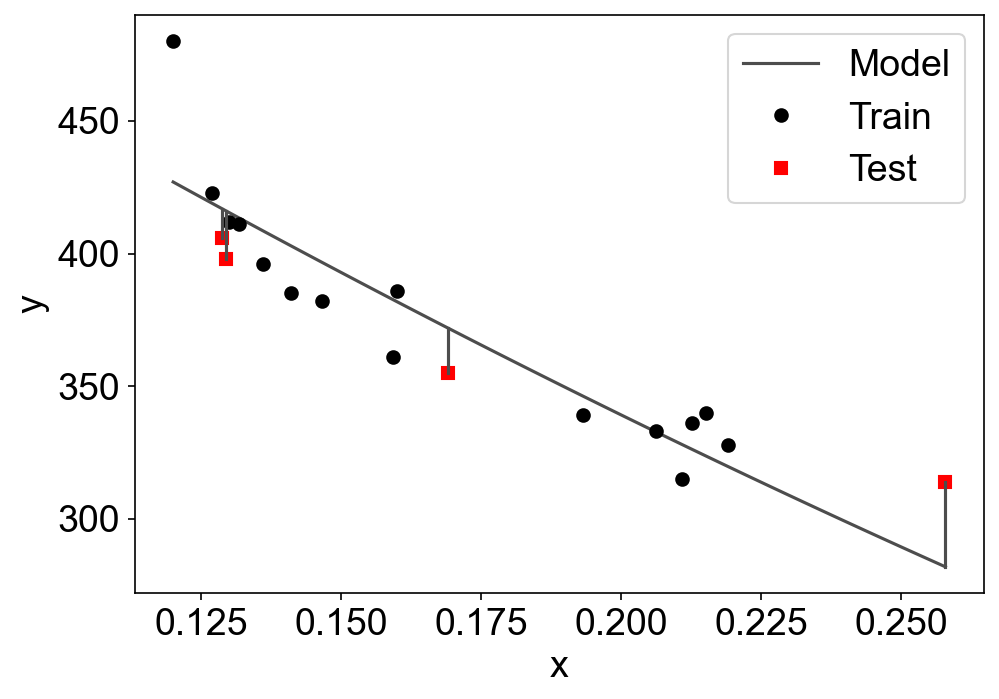

{'model': ElasticNet(),
 'rmse': 26.43995322709816,
 'rmse_std': 12.598491700332604,
 'baseline_rmse': 40.87748316593788,
 'baseline_rmse_std': 13.696493590884202,
 'corr': (-0.8780536471151515, -0.5932158976768389, -0.5441065573110596),
 'corr_std': (0.026906840882069596, 0.10253966031307064, 0.14911017535681748),
 'percent_error': 5.404432083297241,
 'percent_error_std': 2.23238486329376,
 'percent_error_train': 4.396945086926386,
 'percent_error_train_std': 0.461190074709782,
 'r2_score': -0.049713692664102443,
 'r2_score_std': 1.5468034302255274,
 'r2_score_manual': 0.5816371928784423,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [8]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    percent_error_train_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred_train = np.exp(y_pred_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred_train = np.sqrt(y_pred_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred_train = (y_pred_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        percent_error_train = np.mean(np.abs(y_pred_train - y_train)/y_train) * 100
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        percent_error_train_list.append(percent_error_train)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    final_percent_error_train = np.mean(percent_error_train_list)
    final_percent_error_train_std = np.std(percent_error_train_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['percent_error_train'] = final_percent_error_train
    model_output_dict['percent_error_train_std'] = final_percent_error_train_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

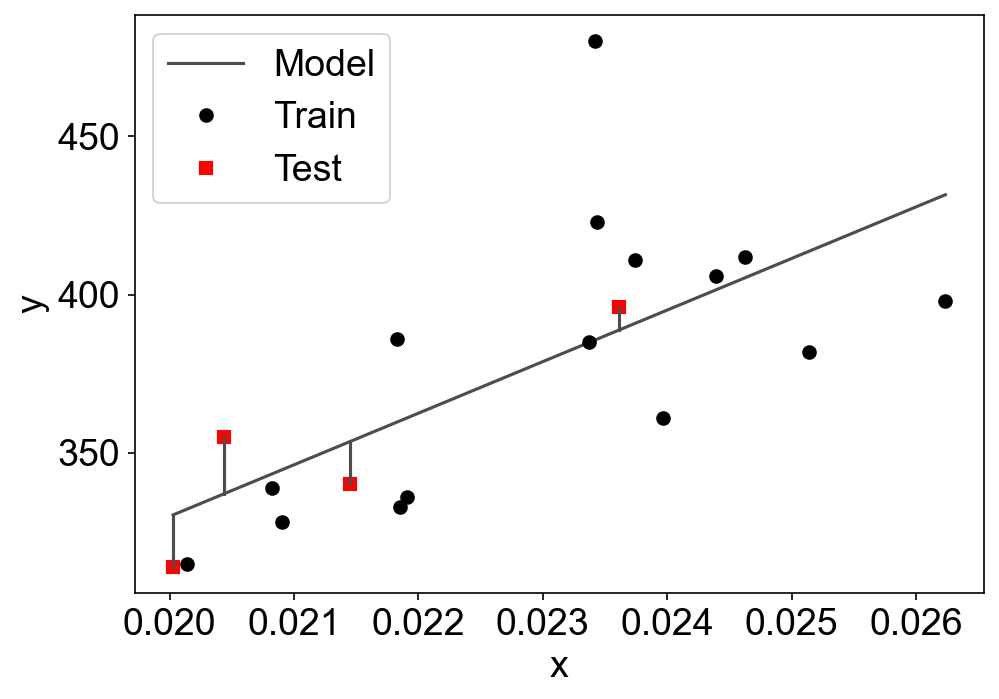

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


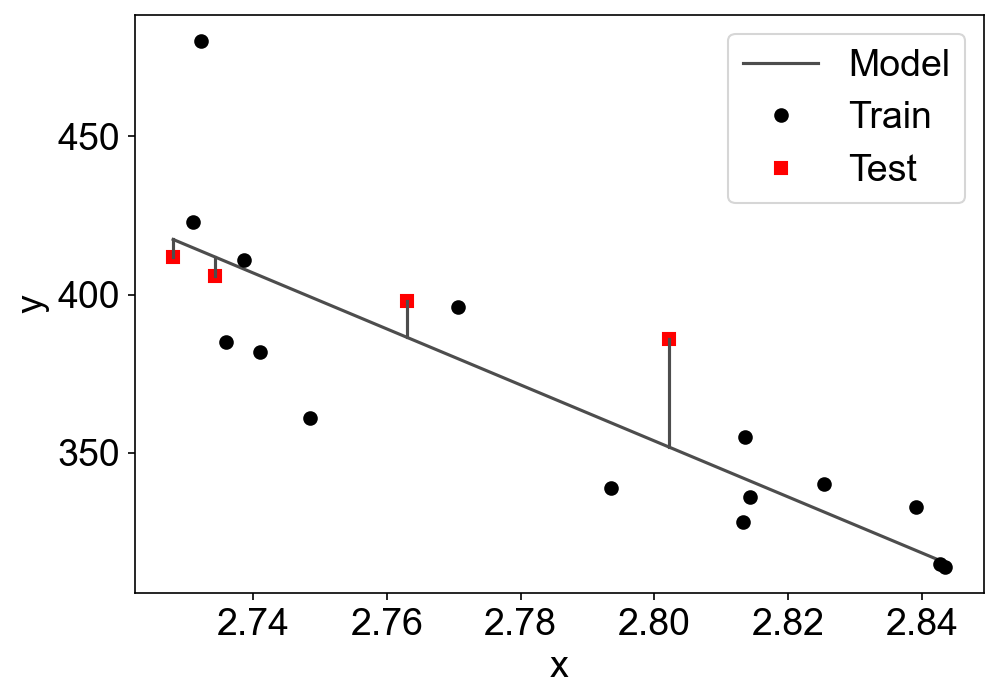

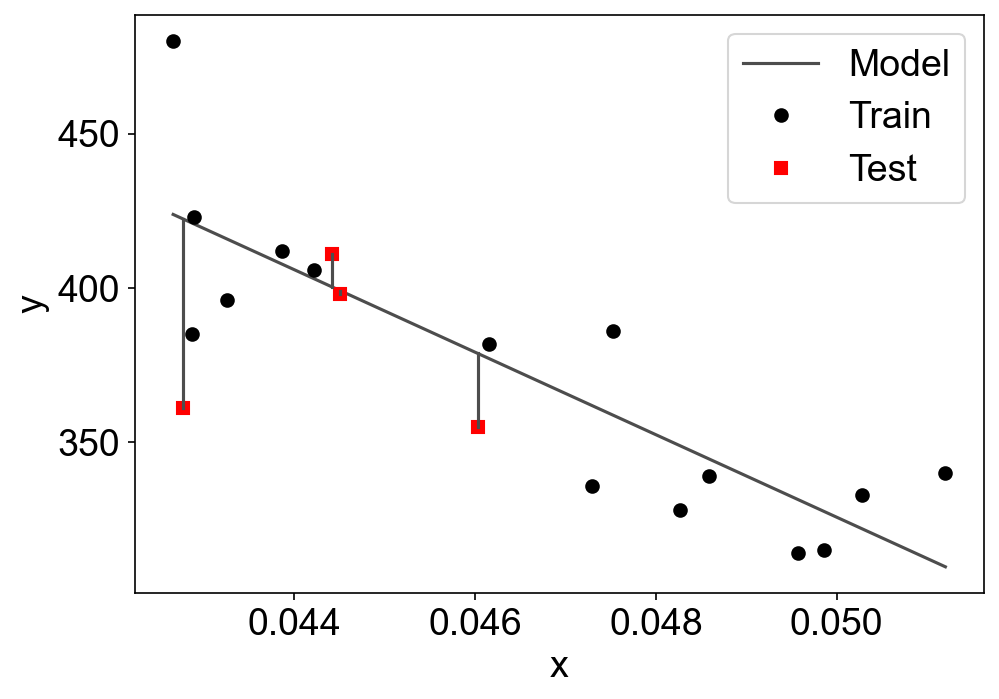

Working on cycle 56...


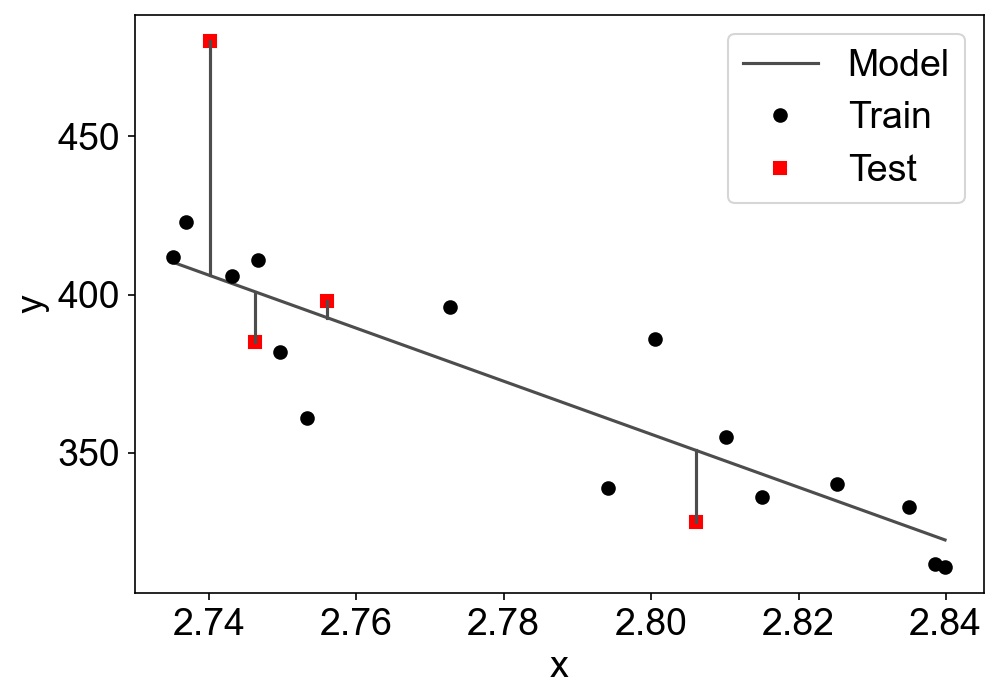

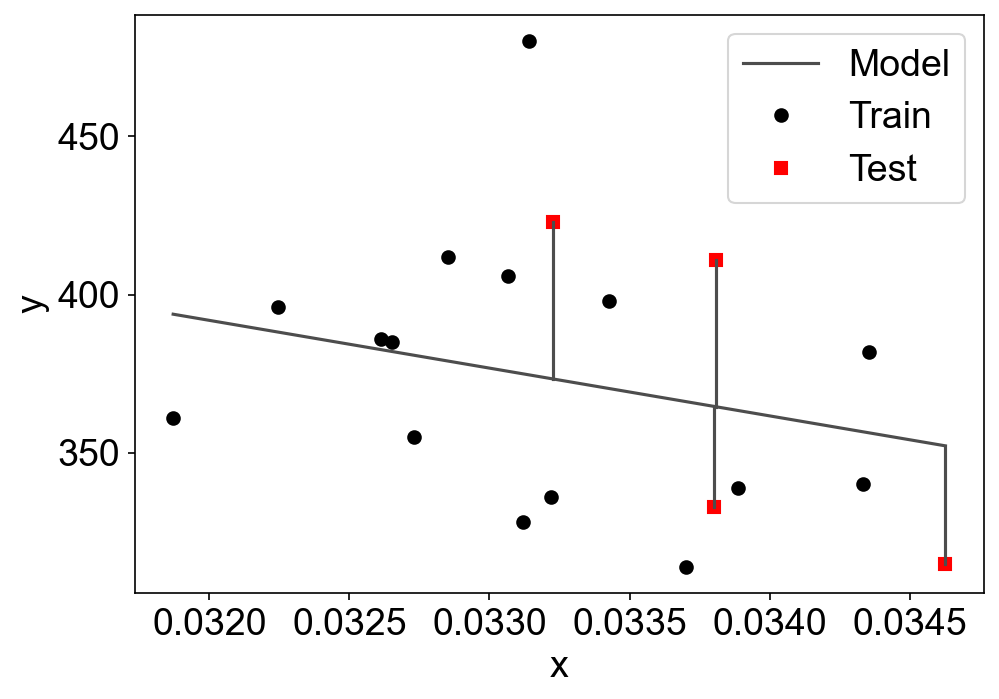

Working on cycle 159...


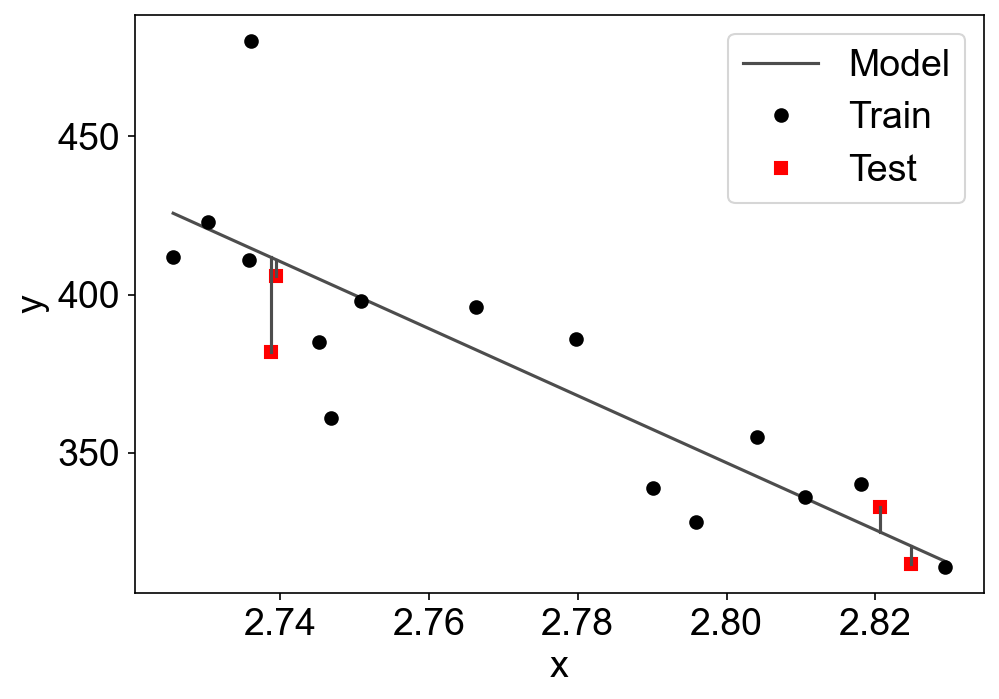

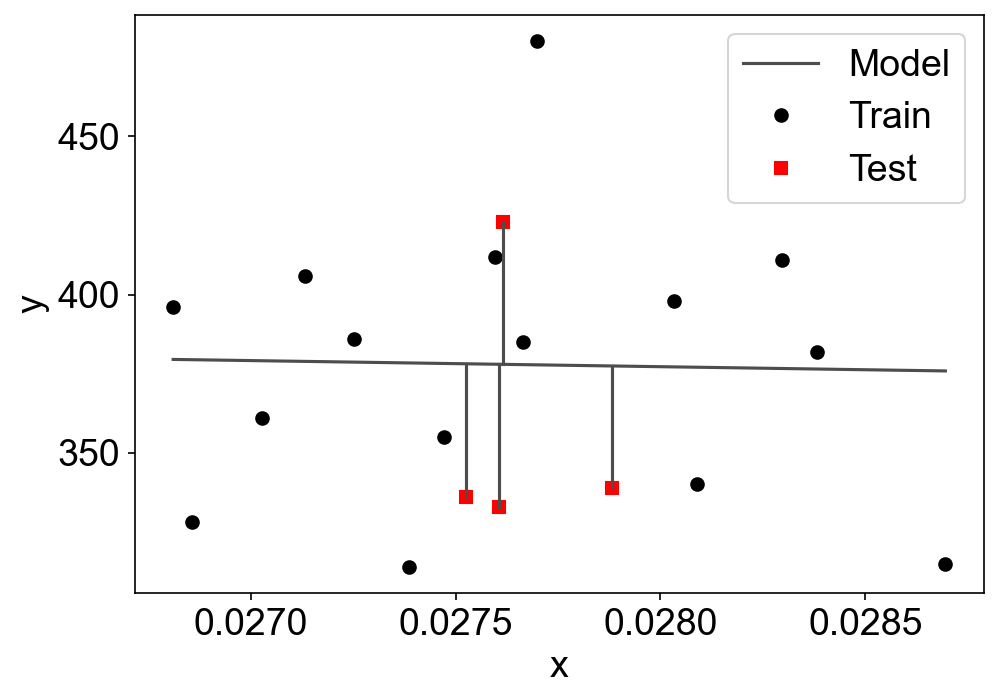

Working on cycle 262...


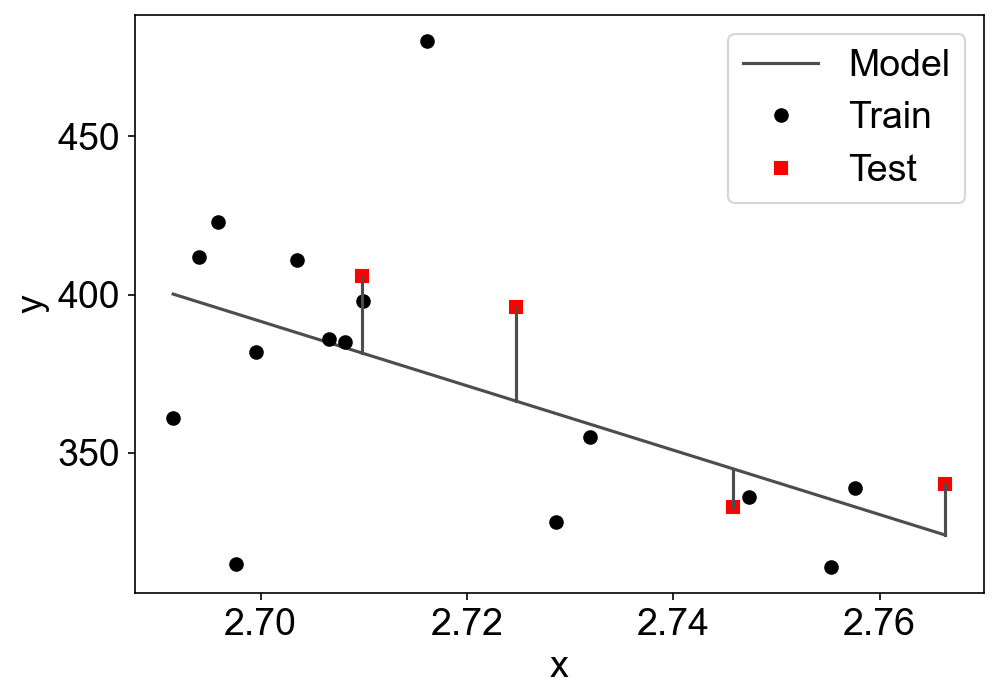

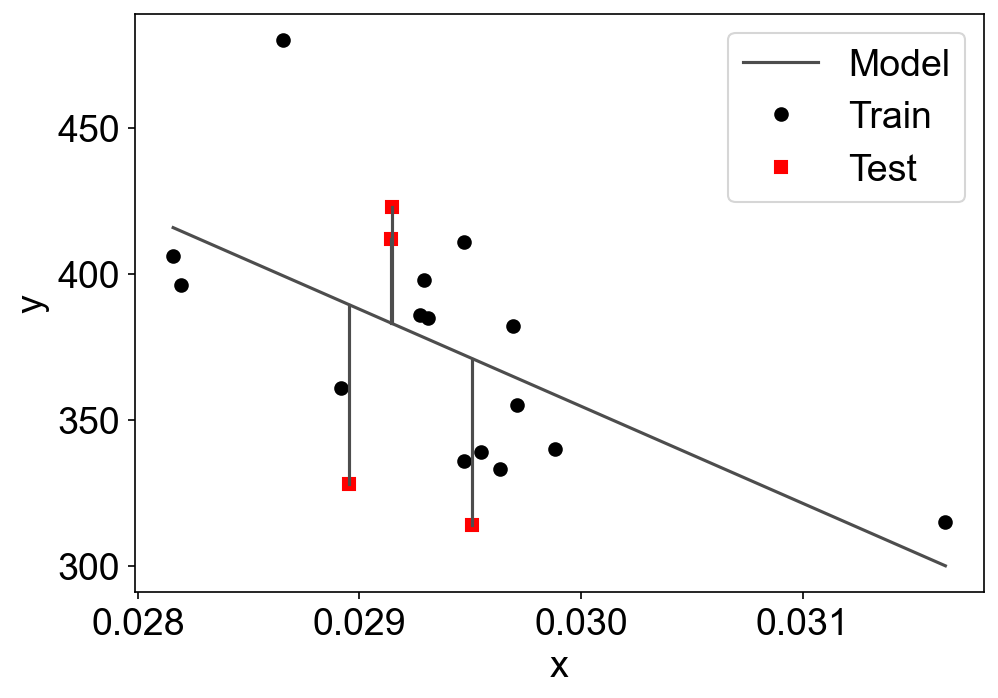

Working on cycle 365...


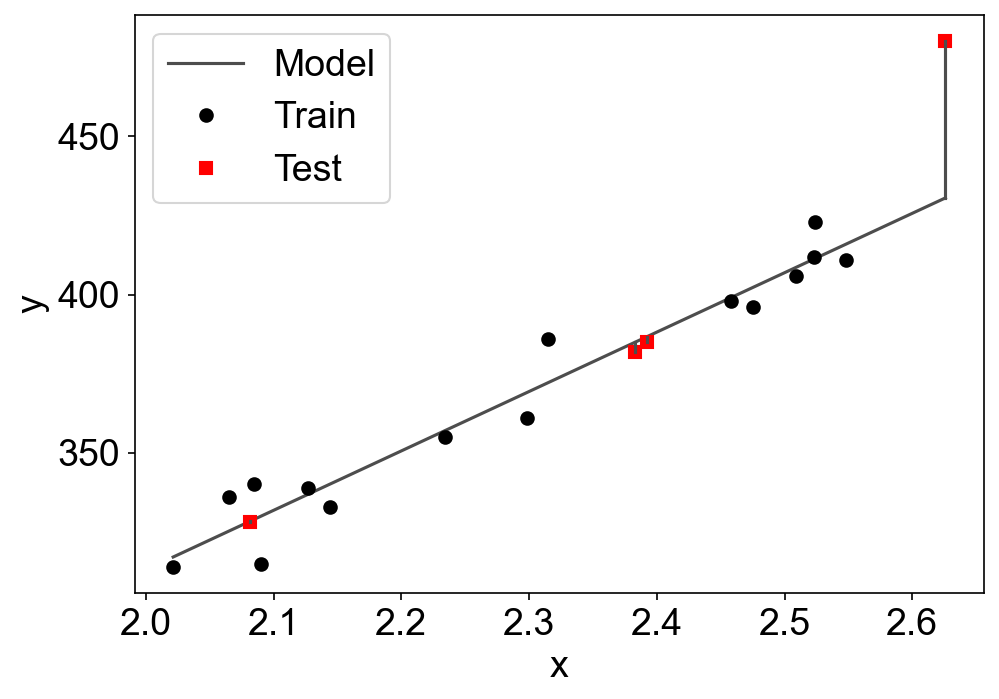

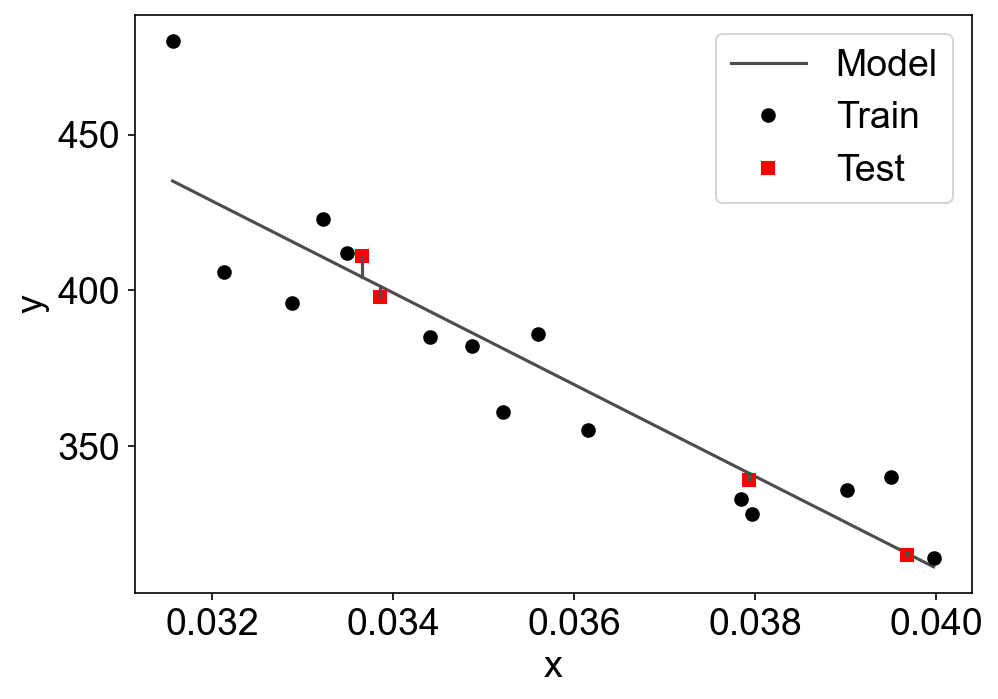

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 32.478604496253745,
   'rmse_std': 14.056247674306357,
   'baseline_rmse': 43.57706207303432,
   'baseline_rmse_std': 12.965138512120427,
   'corr': (0.7140420911303237,),
   'corr_std': (0.06337316366262387,),
   'percent_error': 6.771809605879915,
   'percent_error_std': 2.242943261541552,
   'percent_error_train': 5.717860723522834,
   'percent_error_train_std': 0.6371001738001938,
   'r2_score': -0.0864912784329573,
   'r2_score_std': 1.3779577490556418,
   'r2_score_manual': 0.44450669747761806,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 24.404798333626182,
   'rmse_std': 10.170554608387222,
   'baseline_rmse': 42.87454780662413,
   'baseline_rmse_std': 13.834489724346835,
   'corr': (-0.8521192117923464,),
   'corr_std': (0.029847865607460576,),
   'percent_error': 5.0554512068323,
   'percent_error_std': 1.

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'Cn': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   24.404798333626182,
   22.773798166034652,
   22.259396305580026,
   32.03306470850872,
   12.871479505300163],
  'rmse_std': [nan,
   10.170554608387222,
   11.347975617877534,
   12.149582707284948,
   17.462756472367083,
   6.867656236872029],
  'corr': [nan,
   -0.8521192117923464,
   -0.8522070814526503,
   -0.8603096458912494,
   -0.532426687160936,
   0.9574149128044651],
  'corr_std': [nan,
   0.029847865607460576,
   0.03092039785206979,
   0.03568610443287593,
   0.0984111717224605,
   0.011400948317253806],
  'percent_error': [nan,
   5.0554512068323,
   4.636914155433271,
   4.407288465186671,
   6.822425230955885,
   2.6807154217445595],
  'percent_error_std': [nan,
   1.5850097157391234,
   1.874074494599908,
   1.9006674901807223,
   3.3126540657999124,
   0.9469178922831245]},
 'form_6hr_rest_delta_voltage_v': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [32.478604496253745, nan, nan, nan, nan,

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

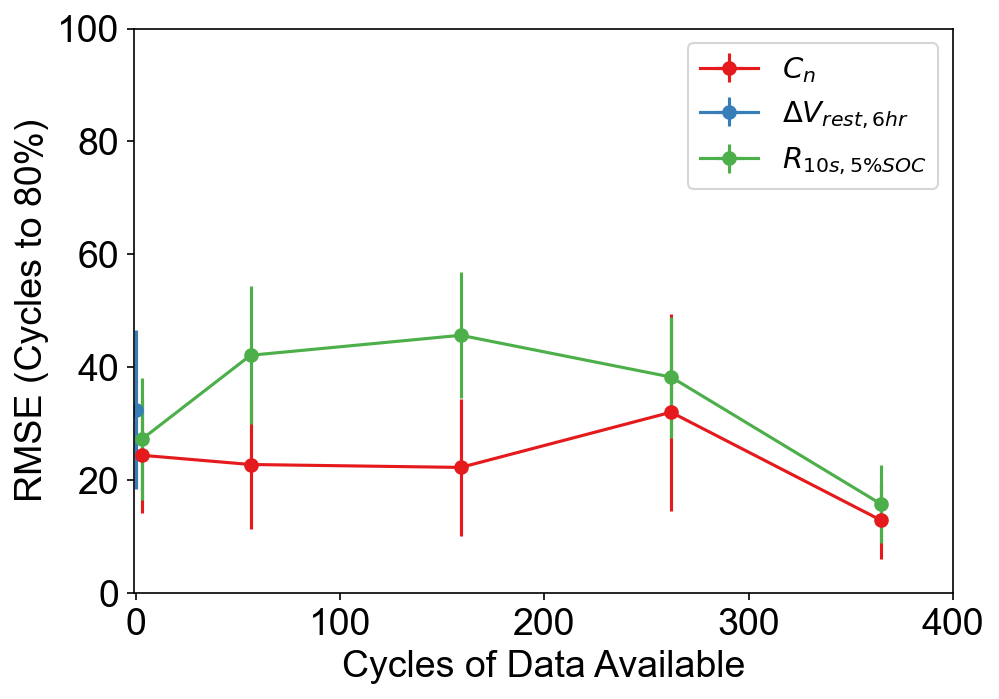

<Figure size 1050x750 with 0 Axes>

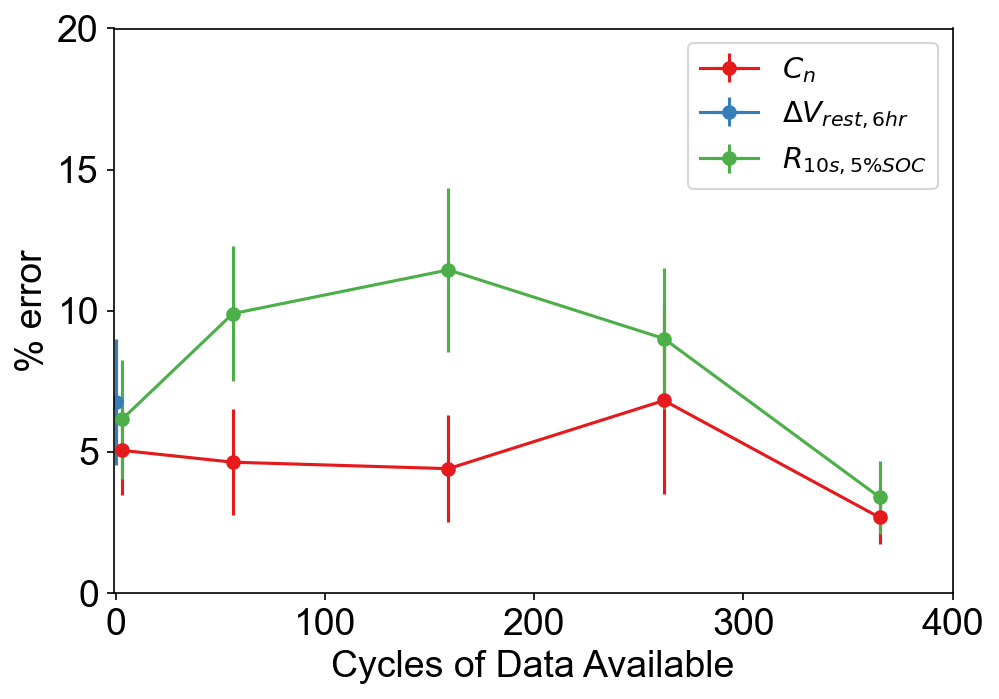

<Figure size 1050x750 with 0 Axes>

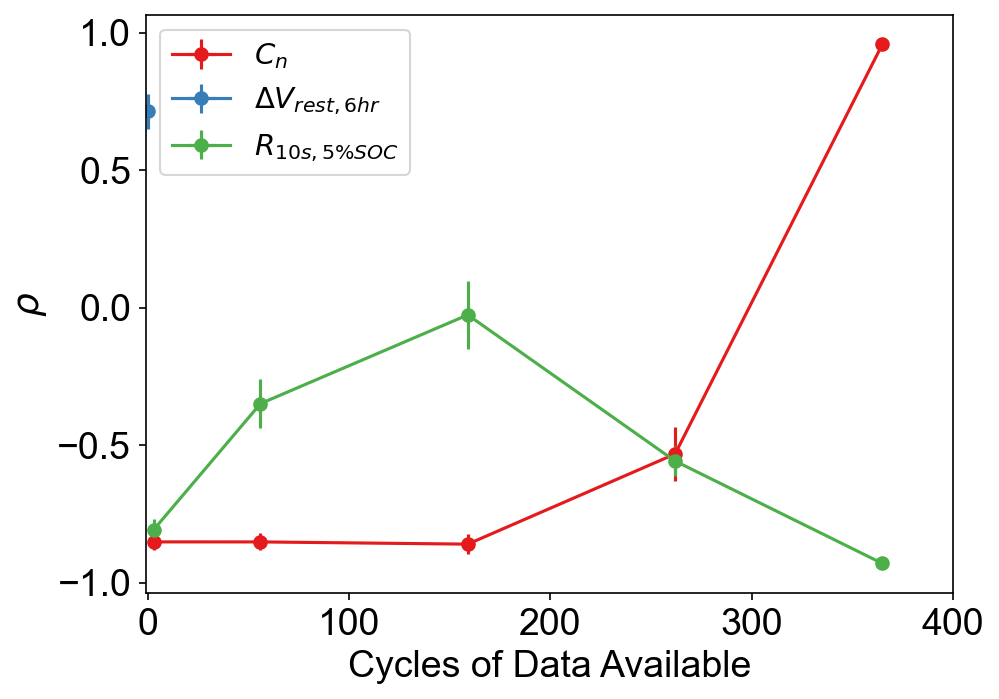

In [14]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)

# Multiple features from formation

## Data analysis

In [15]:
yvar = yvar70

Select relevant formation features

In [16]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 32 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [17]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 32 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [18]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

form_first_discharge_capacity_below_3p2v_ah  \
0                                     0.077820   
1                                     0.073791   
2                                     0.074725   
3                                     0.069433   
4                                     0.073127   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   
4                           3.396888                            3.407243   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   
4                            3.423244                       2.713639   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   
4                          2.330587                     0.858842   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   
4                          2.381257                                 0.011573   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   
4                                 0.015010   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   
4                                 0.017089   

   form_6hr_rest_delta_voltage_v_0_to_4_hr  \
0                                 0.017794   
1                                 0.017002   
2                                 0.018645   
3                                 0.017201   
4                                 0.018494   

   form_6hr_rest_delta_voltage_v_0_to_5_hr  \
0                                 0.018984   
1                                 0.018085   
2                                 0.019790   
3                                 0.018138   
4                                 0.019764   

   form_6hr_rest_delta_voltage_v_0_to_6_hr  \
0                                 0.019909   
1                                 0.018962   
2                                 0.020716   
3                                 0.019097   
4                                 0.020793   

   form_6hr_rest_delta_voltage_v_1_to_6_hr  \
0                                 0.008731   
1                                 0.008188   
2                                 0.009108   
3                                 0.008275   
4                                 0.009128   

   form_6hr_rest_delta_voltage_v_2_to_6_hr  \
0                                 0.005468   
1                                 0.005158   
2                                 0.005626   
3                                 0.005127   
4                             

Look for correlations

In [19]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [20]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [21]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [22]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

<ipython-input-23-c858b667374c>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-23-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
<ipython-input-23-c858b667374c>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


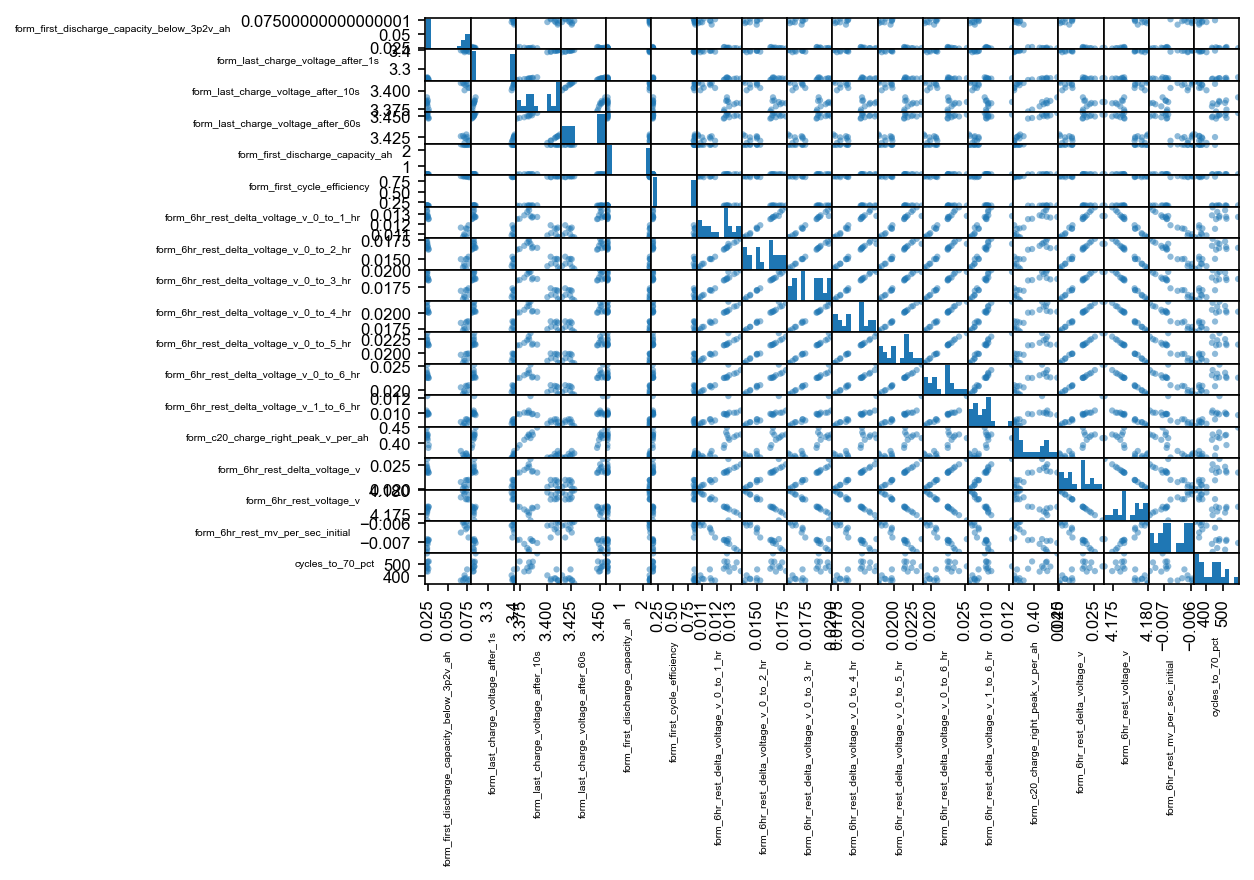

In [23]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "code/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [25]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

form_first_discharge_capacity_below_3p2v_ah  \
count                                    19.000000   
mean                                     -3.198979   
std                                       0.564067   
min                                      -3.766923   
25%                                      -3.729466   
50%                                      -3.649625   
75%                                      -2.626924   
max                                      -2.553354   

       form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
count                          19.000000                           19.000000   
mean                            1.198703                            1.222002   
std                             0.023588                            0.004068   
min                             1.174555                            1.215440   
25%                             1.177094                            1.218782   
50%                             1.179177                            1.221083   
75%                             1.223027                            1.226052   
max                             1.224341                            1.227374   

       form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
count                           19.000000                      19.000000   
mean                             1.234841                       1.003142   
std                              0.004154                       0.012057   
min                              1.228971                       0.988929   
25%                              1.231004                       0.994866   
50%                              1.237599                       0.998291   
75%                              1.238623                       1.009378   
max                              1.239590                       1.037936   

       form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
count                         19.000000                    19.000000   
mean                           0.008368                    -0.994774   
std                            0.812216                     0.816364   
min                           -0.759595                    -1.784166   
25%                           -0.741329                    -1.746586   
50%                           -0.728661                    -1.722820   
75%                            0.838672                    -0.157774   
max                            0.850454                    -0.140043   

       form_final_discharge_capacity_ah  \
count                         19.000000   
mean                           0.860630   
std                            0.004333   
min                            0.854034   
25%                            0.858194   
50%                            0.860109   
75%                            0.862090   
max                            0.869140   

       form_6hr_rest_delta_voltage_v_0_to_1_hr  \
count                                19.000000   
mean                                 -4.416723   
std                                   0.078911   
min                                  -4.538118   
25%                                  -4.481583   
50%                                  -4.382669   
75%                                  -4.360943   
max                                  -4.293166   

       form_6hr_rest_delta_voltage_v_0_to_2_hr  \
count                                19.000000   
mean                                 -4.154705   
std                                   0.081232   
min                                  -4.287379   
25%                                  -4.219624   
50%                                  -4.119745   
75%                                  -4.093166   
max                                  -4.035049   

       form_6hr_rest_delta_voltage_v_0_to_3_hr  \
count                                19.000000   
mean                                 -4.027465   
std                      

In [26]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_70_pct                               1.000000
cycles_to_60_pct                               0.983852
cycles_to_80_pct                               0.978925
cycles_to_50_pct                               0.973508
form_last_charge_voltage_after_60s             0.834031
form_c20_charge_right_peak_v_per_ah            0.808079
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.775806
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.770741
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.770716
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.764190
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.751677
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.749858
form_6hr_rest_delta_voltage_v                  0.747567
form_6hr_rest_mv_per_sec_initial               0.707107
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.689184
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.604837
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.541764
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [27]:
from sklearn.dummy import DummyRegressor

In [28]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.69 (2.48 std)
form_last_charge_voltage_after_1s                 7.39 (2.48 std)
form_last_charge_voltage_after_10s                8.73 (2.73 std)
form_last_charge_voltage_after_60s                7.86 (2.60 std)
form_first_charge_capacity_ah                     14.21 (4.05 std)
form_first_discharge_capacity_ah                  7.34 (2.41 std)
form_first_cycle_efficiency                       7.26 (2.43 std)
form_final_discharge_capacity_ah                  13.33 (4.33 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.02 (3.20 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.78 (3.04 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.59 (2.77 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.88 (2.88 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           9.19 (2.82 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.45 (2.83 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.32 (3.78 std)
form_6h

with log

In [29]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.47 (2.55 std)
form_last_charge_voltage_after_1s                 7.39 (2.56 std)
form_last_charge_voltage_after_10s                8.59 (2.92 std)
form_last_charge_voltage_after_60s                7.56 (2.67 std)
form_first_charge_capacity_ah                     13.98 (3.72 std)
form_first_discharge_capacity_ah                  7.23 (2.60 std)
form_first_cycle_efficiency                       7.38 (2.58 std)
form_final_discharge_capacity_ah                  12.77 (4.22 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.12 (3.19 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.75 (3.10 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.69 (2.82 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.63 (2.72 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           9.01 (2.71 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.36 (2.84 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.06 (4.44 std)
form_6h

### Manual hyperparameter loops

In [30]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [31]:
gridsearch = manual_gridsearch(form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.179896347304748, tolerance: 5.380159999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.663473959226394, tolerance: 5.73296
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.588699608505522, tolerance: 5.3112
  model = cd_fast.enet_coord

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13933.323355255223, tolerance: 7.571493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12763.130472441308, tolerance: 7.003893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10718.12171242354, tolerance: 7.075573333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11147.426611666924, tolerance: 8.2796
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13124.320968161053, tolerance: 8.335493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14199.723430015643, tolerance: 7.668533333333333
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12671.292707291372, tolerance: 7.6065733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15314.394849438691, tolerance: 6.687040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12955.162748837225, tolerance: 7.5418933333333324
  m

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15091.713740567855, tolerance: 6.994933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9738.533101835834, tolerance: 5.2342933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13942.415350213872, tolerance: 6.42516
  model = cd_fa

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12108.750384020113, tolerance: 6.926373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9713.435934191551, tolerance: 5.174573333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15492.904241322824, tolerance: 7.5057599999999995
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15553.437420095306, tolerance: 7.038773333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12788.747818117068, tolerance: 7.53984
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13029.638349879275, tolerance: 8.497733333333334
  model = cd_fa

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10515.084549189216, tolerance: 5.6987733333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10081.3535399452, tolerance: 4.923093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15799.02601733886, tolerance: 6.75984
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16683.129377642337, tolerance: 7.038373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17049.949061188596, tolerance: 6.517733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15592.24221927698, tolerance: 7.464373333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14689.332704068824, tolerance: 6.797760000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18367.683286249816, tolerance: 7.357733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14944.287881434284, tolerance: 8.150933333333334
  mod

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10834.580349180087, tolerance: 4.706293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17334.286549023505, tolerance: 7.308973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18015.238900962348, tolerance: 7.605973333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18379.766386845007, tolerance: 6.922573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17594.80205884484, tolerance: 7.136293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19464.114690018145, tolerance: 7.479693333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18155.46123200338, tolerance: 7.765333333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19298.282398281743, tolerance: 8.131440000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17618.942436350797, tolerance: 7.302560000000001
  mode

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20903.490667993367, tolerance: 7.625040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22048.737948580834, tolerance: 7.484373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19661.37271549291, tolerance: 6.8274
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22204.455300582675, tolerance: 7.142173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19810.546028349592, tolerance: 7.117493333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22351.120581961775, tolerance: 7.195733333333335
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13004.98127118672, tolerance: 5.27556
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20982.791646906, tolerance: 6.941533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21059.04789228974, tolerance: 7.120933333333334
  model = cd_fast.en

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22924.104708967938, tolerance: 7.181533333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15082.666248087378, tolerance: 5.128373333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22346.889955285817, tolerance: 7.464373333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15668.148636011098, tolerance: 5.1471333333333344
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22533.209873844993, tolerance: 6.637933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23382.454306984702, tolerance: 7.177573333333334
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22287.6326431979, tolerance: 7.129093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22113.364933845332, tolerance: 6.993573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23552.315408935632, tolerance: 6.916693333333332
  model

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26370.742828408092, tolerance: 7.6971733333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27139.380585625495, tolerance: 7.6151599999999995
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25777.213615585315, tolerance: 6.947893333333332
  m

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25741.21243935106, tolerance: 6.733760000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26620.237027748142, tolerance: 7.311173333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17314.832161725917, tolerance: 5.069160000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27829.262559348135, tolerance: 7.5203733333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28838.851234679096, tolerance: 8.561293333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24121.07768003943, tolerance: 6.352200000000001
  mod

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25848.88145105038, tolerance: 6.398733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29057.075123271552, tolerance: 7.111893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26910.45554694842, tolerance: 6.589733333333335
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26144.700000489916, tolerance: 6.3273600000000005
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27455.23196544238, tolerance: 6.92024
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29987.11226507587, tolerance: 7.494693333333332
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30055.212048909354, tolerance: 7.49484
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31044.742371998196, tolerance: 8.092933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25769.505259006037, tolerance: 6.319933333333333
  model = cd_fa

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30849.677705911152, tolerance: 7.223173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26665.333027721186, tolerance: 6.147893333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34026.71809917898, tolerance: 8.047373333333331
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31198.541403819814, tolerance: 7.459093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33185.45310446447, tolerance: 7.948093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31280.043515367674, tolerance: 7.156693333333335
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28616.894838981036, tolerance: 6.511773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31441.27648360672, tolerance: 7.489173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29709.677424879246, tolerance: 6.828893333333334
  mode

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19438.177414437436, tolerance: 4.351293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32665.858913492048, tolerance: 7.189173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34365.35001021116, tolerance: 7.587093333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30260.09141210945, tolerance: 6.635573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32477.2914686588, tolerance: 7.1222933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32142.2334112044, tolerance: 7.091693333333334
  model =

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29489.15466862568, tolerance: 6.44004
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23653.39398968266, tolerance: 5.343839999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35788.92308529619, tolerance: 7.9396933333333335
  model = cd_fast

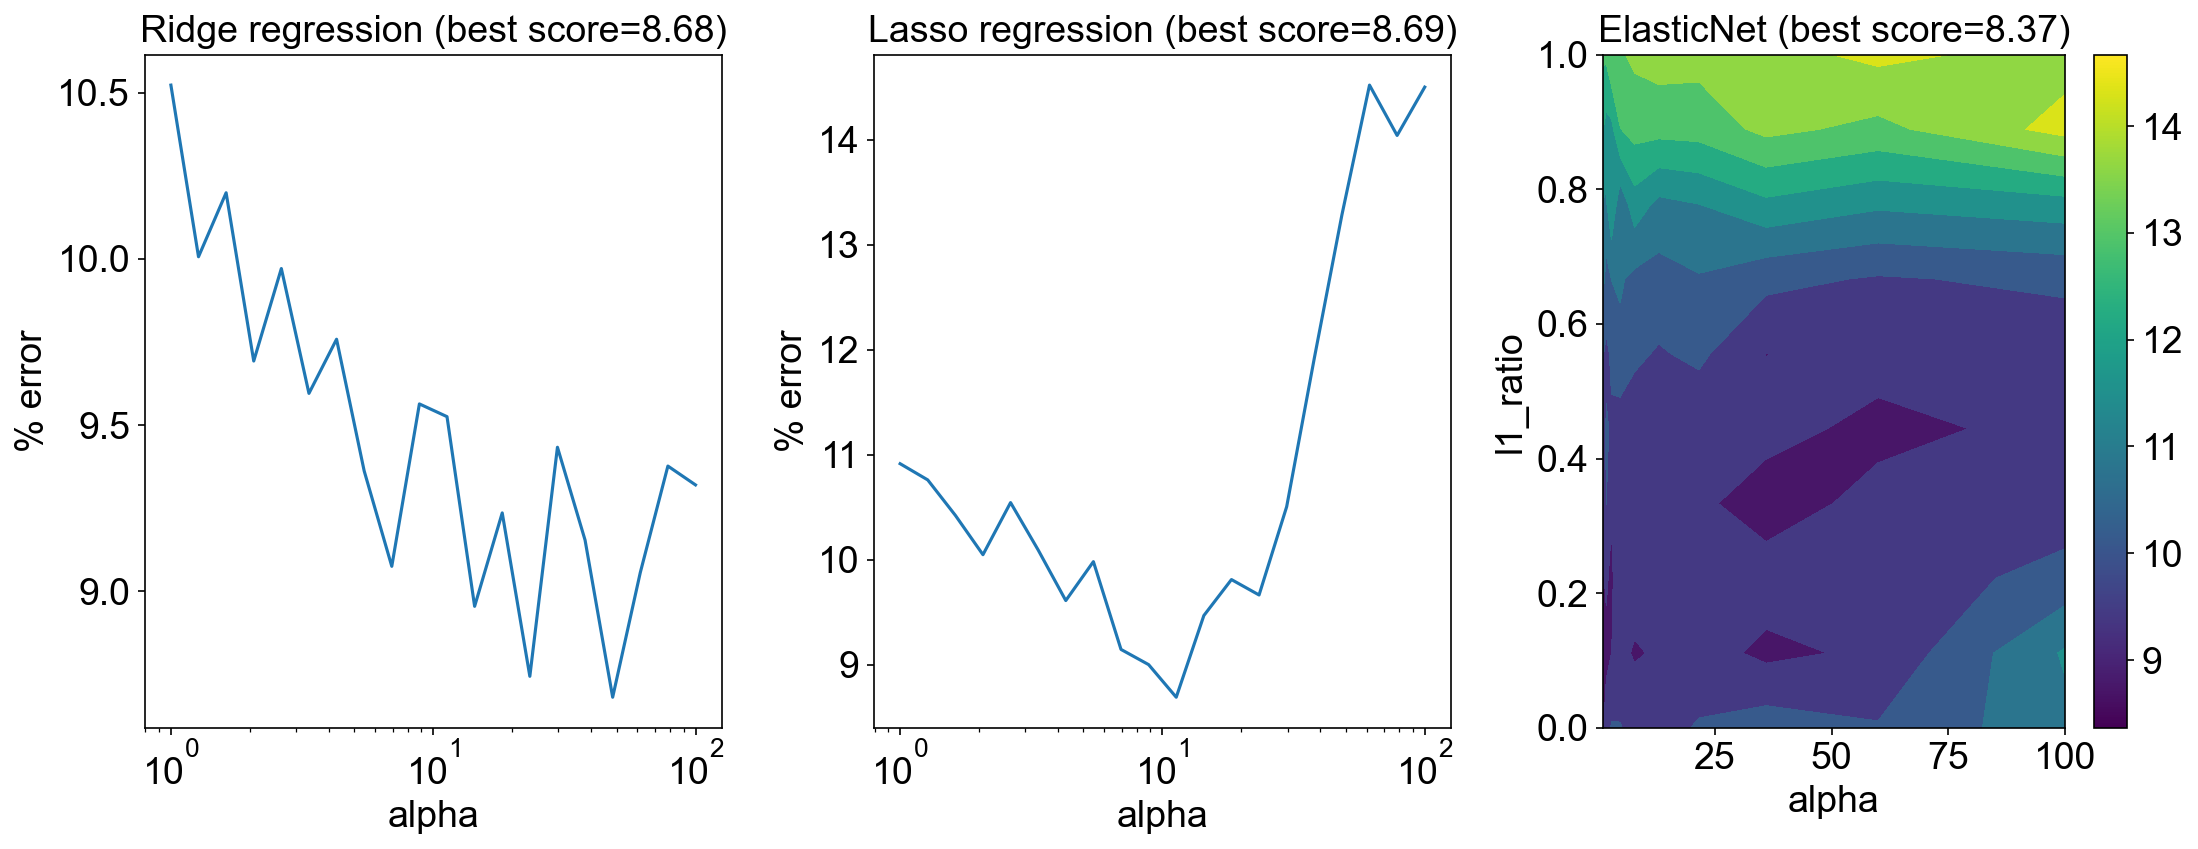

In [32]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [33]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5543471756082, tolerance: 4.4538
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.159991294156498, tolerance: 5.026493333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.697231527312397, tolerance: 5.670773333333333
  model = cd_fast.en

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11624.173118812323, tolerance: 8.463000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14267.677763213107, tolerance: 6.105493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13508.774989787187, tolerance: 7.8761333333333345
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13713.88856105378, tolerance: 7.010160000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9014.293100238192, tolerance: 4.987293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15319.876528337278, tolerance: 6.311893333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.611397691494858, tolerance: 5.061493333333335
  model = cd_fast.enet_coordinate_descent(


1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9484.10837765982, tolerance: 5.204159999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15136.444346240034, tolerance: 8.06624
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14861.457995518542, tolerance: 6.87184
  model = cd_fast.enet_coor

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14555.203976666577, tolerance: 7.834773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16365.377697390042, tolerance: 7.517573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15464.943170523458, tolerance: 7.3234400000000015
  mo

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.462680127018757, tolerance: 5.241293333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17361.291006088515, tolerance: 6.6830933333333356
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17521.33882432006, tolerance: 6.552533333333334
  mod

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17244.487530410588, tolerance: 7.82816
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17158.866615920564, tolerance: 6.879933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18126.07473945637, tolerance: 7.824533333333335
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11226.717346192127, tolerance: 5.920933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18466.18504959081, tolerance: 7.333133333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18326.874573120764, tolerance: 7.5627733333333325
  mod

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18160.94452165516, tolerance: 6.2930399999999995
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13034.343480076426, tolerance: 5.653573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18024.91657711959, tolerance: 8.029173333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20026.678295180496, tolerance: 7.847693333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11543.859765858359, tolerance: 5.11524
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341.274727155778, tolerance: 5.597293333333334
  model = cd_fa

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21636.410918011195, tolerance: 7.575893333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13164.77200671704, tolerance: 5.061493333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20983.694130014603, tolerance: 7.474933333333333
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20117.3739976579, tolerance: 6.845360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13799.385297280436, tolerance: 5.185893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13335.08928445757, tolerance: 4.887493333333333
  model 

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23135.303002015884, tolerance: 6.9946399999999995
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23893.312552466417, tolerance: 7.492773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18498.93577377985, tolerance: 5.984293333333333
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24830.64725987697, tolerance: 7.587093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25410.150283955863, tolerance: 7.533573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25564.724423965432, tolerance: 7.652693333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.002846653875167, tolerance: 6.0726933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28765.842933260643, tolerance: 8.202893333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24690.018765586163, tolerance: 6.388533333333334
  mod

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26407.274704447696, tolerance: 6.905573333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28265.791175816983, tolerance: 7.770560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19915.413518359397, tolerance: 5.768160000000001
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28124.67076496644, tolerance: 8.071093333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19748.429109416116, tolerance: 5.50064
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27460.215171358326, tolerance: 7.212773333333334
  model = cd_fas

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31216.011403958793, tolerance: 7.679040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20631.38496088931, tolerance: 5.0494933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28726.4855749714, tolerance: 7.1251733333333345
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26700.147041525695, tolerance: 6.265493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20941.090029546896, tolerance: 5.320173333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30650.657548276482, tolerance: 7.594293333333334
  mod

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25320.36993867637, tolerance: 5.686973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32541.466035985242, tolerance: 7.595493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35010.39237336464, tolerance: 8.04504
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30958.77624662299, tolerance: 7.055293333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31264.42694113854, tolerance: 7.111493333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28694.994061392983, tolerance: 6.491293333333334
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21430.560179462762, tolerance: 5.0388
  model = cd_fast.enet_coordinate_descent(


9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34497.366542112526, tolerance: 7.517840000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22191.40404148678, tolerance: 4.8878933333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23209.159492373205, tolerance: 5.140293333333334
  mod

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34213.1804489821, tolerance: 7.5224
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33336.80702819777, tolerance: 7.2334933333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33957.97181864037, tolerance: 7.420133333333333
  model = cd_fast.e

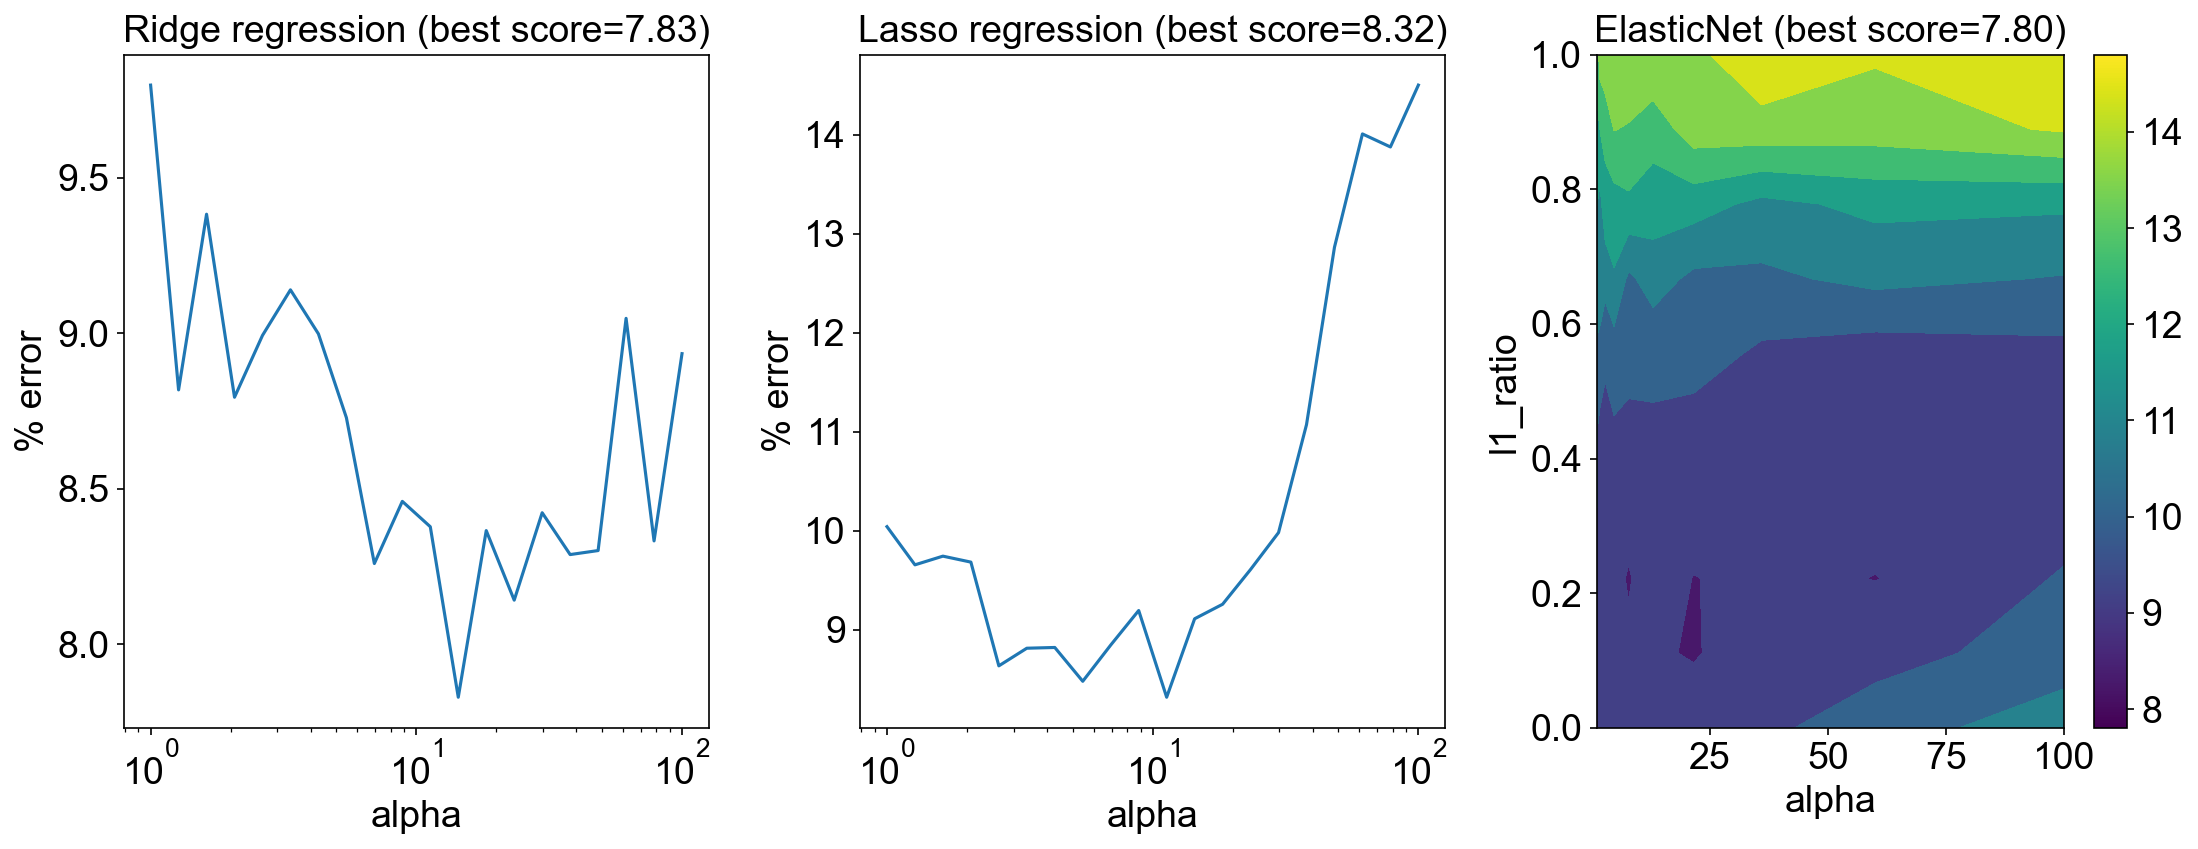

In [34]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25443.982883590274, tolerance: 8.201093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26045.63069177403, tolerance: 7.68184
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25910.06050831448, tolerance: 7.675573333333334
  model = cd_fast

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27116.177041320127, tolerance: 7.216560000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27824.100962893055, tolerance: 7.496933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25577.657810862824, tolerance: 6.669973333333334
  mod

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23415.255740029505, tolerance: 6.044693333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23591.910309569685, tolerance: 5.880173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31446.08336739395, tolerance: 7.786533333333333
  mode

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33100.30983155475, tolerance: 7.5396
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33786.83714463992, tolerance: 7.831093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31337.4623422258, tolerance: 7.057093333333333
  model = cd_fast.en

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35699.35412621145, tolerance: 7.754773333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31553.927817994027, tolerance: 6.804973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35164.91821835894, tolerance: 7.649759999999998
  model

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34156.98501370593, tolerance: 7.150373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35396.542056166065, tolerance: 7.459093333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30844.631656100344, tolerance: 6.439573333333334
  mode

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25742.872614754862, tolerance: 5.308559999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37608.75692126138, tolerance: 7.76304
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35044.69089770343, tolerance: 7.21184
  model = cd_fast.enet_coor

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33034.76264755372, tolerance: 6.72636
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38934.80917492175, tolerance: 7.9396933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39678.39542660766, tolerance: 8.084293333333333
  model = cd_fast

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35039.8652080712, tolerance: 7.079573333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38345.86582925026, tolerance: 7.756200000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25138.527364257807, tolerance: 5.088933333333333
  model 

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37171.988215786565, tolerance: 7.485173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32911.91398068848, tolerance: 6.622040000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24938.258067261148, tolerance: 5.023493333333333
  mode

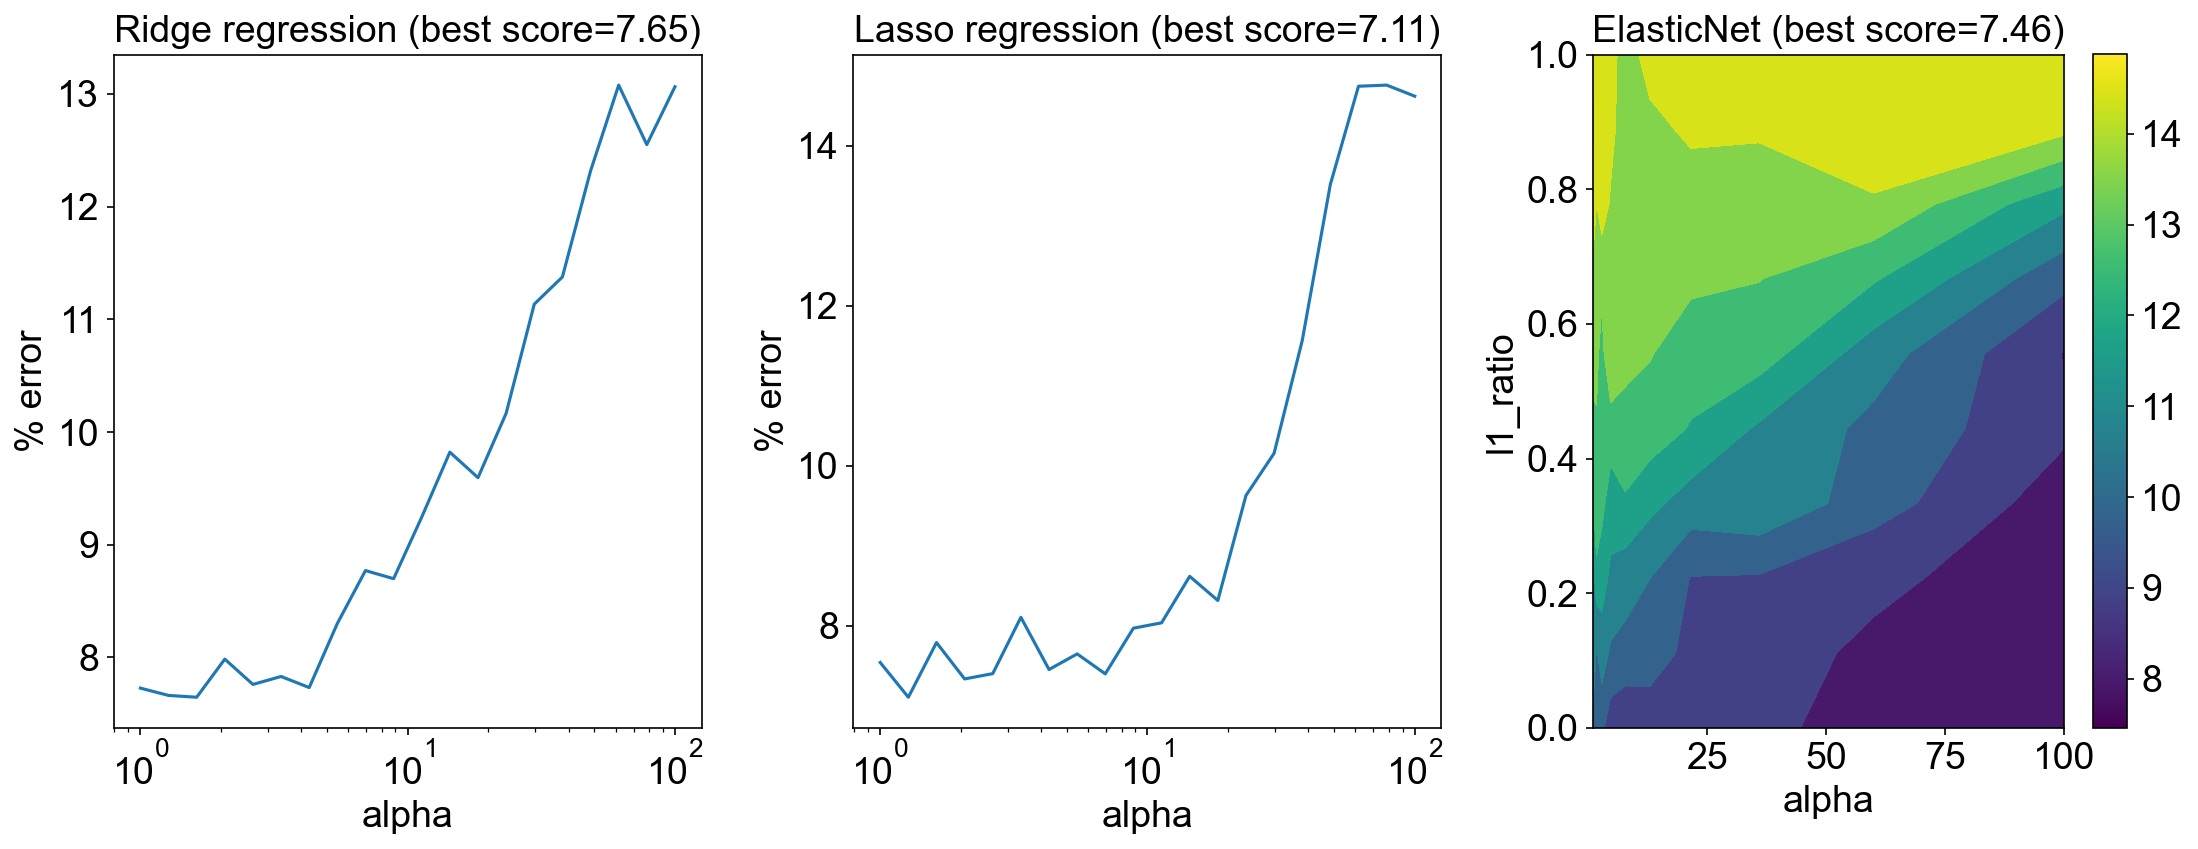

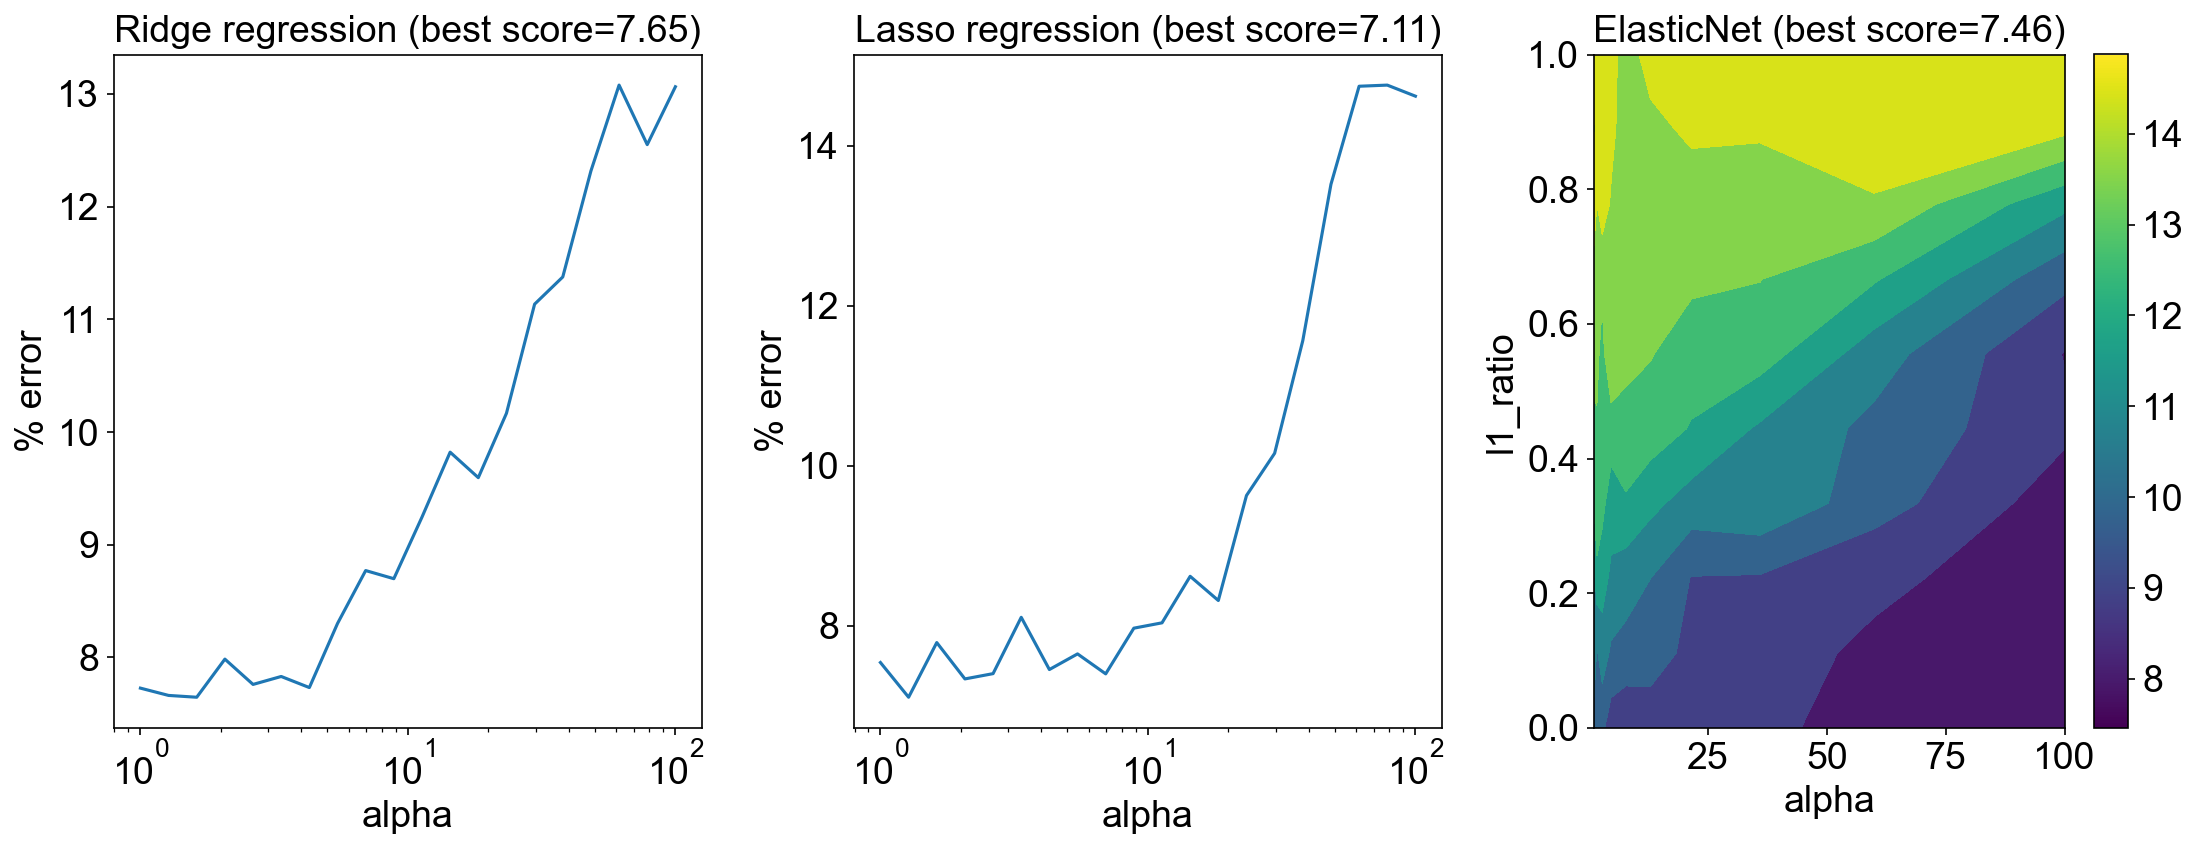

In [35]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [36]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.02458138678594, tolerance: 5.58576
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.214251503970445, tolerance: 5.411693333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.698195519767978, tolerance: 4.5654
  model = cd_fast.enet_coordin

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6033190925263625, tolerance: 5.163773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.514269302457251, tolerance: 5.11224
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.14904655686405, tolerance: 5.610773333333334
  model = cd_fast.

0


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9976.945277880492, tolerance: 4.551293333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15466.517994366195, tolerance: 7.550293333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14917.68660477467, tolerance: 7.888533333333336
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13967.506916791426, tolerance: 5.867373333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16444.10329643073, tolerance: 7.533573333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15063.740616810057, tolerance: 7.939693333333335
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.318176585764377, tolerance: 5.1793733333333325
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15531.78137110381, tolerance: 7.81896
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17100.899863277788, tolerance: 7.529493333333334
  model = cd_fas

1


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17275.721107950543, tolerance: 7.835933333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11503.60655835621, tolerance: 4.708693333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15759.090254907387, tolerance: 8.27829333333333
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.38425146046211, tolerance: 5.688373333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.365049001578882, tolerance: 5.702933333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.096540306733004, tolerance: 5.320173333333333
  model =

2


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17909.649272390932, tolerance: 6.92024
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19843.881644352947, tolerance: 6.964293333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19427.83488211566, tolerance: 7.134733333333333
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.669559869089426, tolerance: 5.816933333333336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.118060809796589, tolerance: 5.528640000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.693648428070446, tolerance: 5.308560000000001
  model 

3


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21693.76807002561, tolerance: 6.723733333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23063.46417657221, tolerance: 8.436493333333331
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17128.23623762661, tolerance: 5.62496
  model = cd_fast.

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.838380240467814, tolerance: 5.293693333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.243365874652227, tolerance: 5.7174933333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.957765754112188, tolerance: 5.565359999999999
  model

4


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20143.664659500057, tolerance: 5.733840000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18315.790435248164, tolerance: 5.086773333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26370.16979194931, tolerance: 7.989973333333334
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.388116710260874, tolerance: 5.429173333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.635557204703218, tolerance: 4.416360000000001
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.817931414938357, tolerance: 5.6676
  model = cd_fast.e

5


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28438.763981589636, tolerance: 7.436133333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28379.90960773709, tolerance: 7.1651733333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28299.843490218263, tolerance: 7.306559999999999
  mod

6


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30635.01723142862, tolerance: 7.142973333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32660.952420350375, tolerance: 7.602173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22863.779638247583, tolerance: 5.382000000000001
  mode

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31143.416430716272, tolerance: 7.342293333333335
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33323.796109943534, tolerance: 7.824533333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29404.201624927016, tolerance: 6.805840000000001
  mod

7


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23023.13686534868, tolerance: 5.079093333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32507.919652351877, tolerance: 7.165039999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33546.40426575228, tolerance: 7.374693333333335
  model

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27797.524875770745, tolerance: 6.057733333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32247.70826115635, tolerance: 7.089359999999999
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29222.79599425787, tolerance: 6.444773333333334
  model

8


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34856.42637308832, tolerance: 7.4329333333333345
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30192.50792859565, tolerance: 6.392893333333333
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27257.25962783234, tolerance: 5.82504
  model = cd_fast

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33786.76990153283, tolerance: 7.217173333333332
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27407.791844182662, tolerance: 5.77656
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36640.31537705241, tolerance: 7.799933333333334
  model = cd_fast

9


/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38484.37761058585, tolerance: 8.039173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24166.566228379164, tolerance: 5.01516
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31492.319683164744, tolerance: 6.547493333333335
  model = cd_fas

/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25564.17713501878, tolerance: 5.33336
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23654.51491233693, tolerance: 4.917173333333334
  model = cd_fast.enet_coordinate_descent(
/Users/vsulzer/Documents/Energy_storage/project-formation/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32575.35147828589, tolerance: 6.742373333333332
  model = cd_fast.

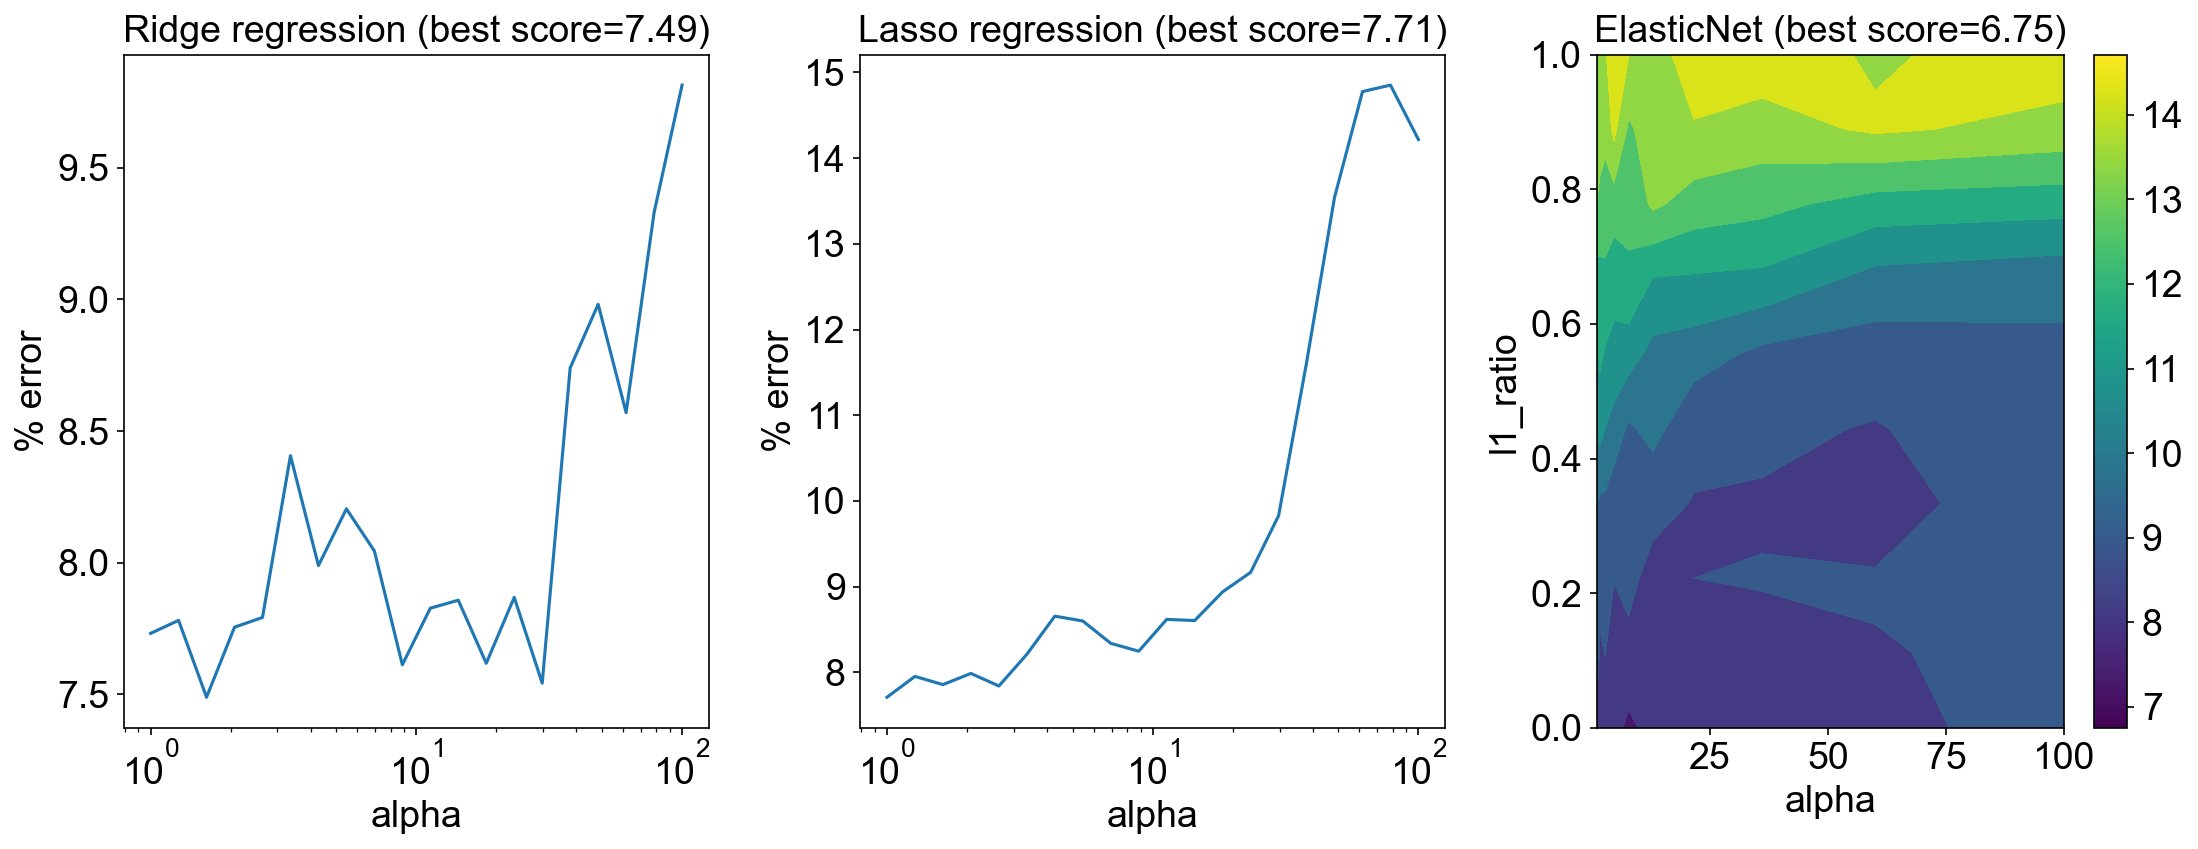

In [37]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [38]:
yvar

'cycles_to_70_pct'

## Printing lots of models

In [39]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [40]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.53 (2.61 std)
form_last_charge_voltage_after_1s                 7.62 (2.52 std)
form_last_charge_voltage_after_60s                7.71 (2.64 std)
form_first_discharge_capacity_ah                  7.37 (2.42 std)
form_first_cycle_efficiency                       7.38 (2.45 std)
form_c20_charge_right_peak_v_per_ah               8.35 (2.62 std)
Dummy regressor (predict mean)          14.14 (4.04 std)
very high corr                          13.21 (3.80 std)
high corr                               12.19 (3.74 std)
all                                     12.05 (3.84 std)


In [41]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.29 (2.47 std)
form_last_charge_voltage_after_1s                 7.34 (2.38 std)
form_last_charge_voltage_after_60s                7.05 (2.29 std)
form_first_discharge_capacity_ah                  7.03 (2.41 std)
form_first_cycle_efficiency                       7.19 (2.35 std)
form_c20_charge_right_peak_v_per_ah               7.97 (2.22 std)
Dummy regressor (predict mean)          12.86 (3.07 std)
very high corr                          7.20 (2.35 std)
high corr                               7.79 (2.36 std)
all                                     8.93 (2.62 std)


In [42]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.12 (2.52 std)
form_last_charge_voltage_after_1s                 7.27 (2.40 std)
form_last_charge_voltage_after_60s                7.02 (2.25 std)
form_first_discharge_capacity_ah                  7.11 (2.34 std)
form_first_cycle_efficiency                       7.09 (2.42 std)
form_c20_charge_right_peak_v_per_ah               8.04 (2.25 std)
Dummy regressor (predict mean)          12.83 (3.01 std)
very high corr                          7.27 (2.31 std)
high corr                               7.54 (2.31 std)
all                                     8.99 (2.69 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.67 (2.58 std)
form_last_charge_voltage_after_1s                 7.41 (2.55 std)
form_last_charge_voltage_after_60s                7.44 (2.57 std)
form_first_discharge_capacity_ah                  7.40 (2.53 std)
form_first_cycle_efficiency      

In [43]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.13 (2.42 std)
form_last_charge_voltage_after_1s                 7.15 (2.43 std)
form_last_charge_voltage_after_60s                7.02 (2.26 std)
form_first_discharge_capacity_ah                  6.88 (2.29 std)
form_first_cycle_efficiency                       7.00 (2.37 std)
form_c20_charge_right_peak_v_per_ah               8.05 (2.27 std)
Dummy regressor (predict mean)          12.66 (2.96 std)
very high corr                          7.14 (2.27 std)
high corr                               7.35 (2.42 std)
all                                     8.60 (2.60 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.39 (2.42 std)
form_last_charge_voltage_after_1s                 7.53 (2.55 std)
form_last_charge_voltage_after_60s                7.06 (2.41 std)
form_first_discharge_capacity_ah                  7.35 (2.59 std)
form_first_cycle_efficiency      

In [44]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.52 (2.58 std)
form_last_charge_voltage_after_1s                 7.36 (2.41 std)
form_last_charge_voltage_after_60s                7.33 (2.43 std)
form_first_discharge_capacity_ah                  7.23 (2.39 std)
form_first_cycle_efficiency                       7.18 (2.36 std)
form_c20_charge_right_peak_v_per_ah               8.03 (2.30 std)
Dummy regressor (predict mean)          12.92 (3.34 std)
very high corr                          7.41 (2.33 std)
high corr                               7.87 (2.47 std)
all                                     9.62 (2.94 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.75 (2.71 std)
form_last_charge_voltage_after_1s                 7.48 (2.58 std)
form_last_charge_voltage_after_60s                7.65 (2.62 std)
form_first_discharge_capacity_ah                  7.31 (2.62 std)
form_first_cycle_efficiency      

In [45]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.19 (2.52 std)
form_last_charge_voltage_after_1s                 7.12 (2.46 std)
form_last_charge_voltage_after_60s                7.17 (2.26 std)
form_first_discharge_capacity_ah                  7.01 (2.42 std)
form_first_cycle_efficiency                       6.96 (2.36 std)
form_c20_charge_right_peak_v_per_ah               8.00 (2.20 std)
Dummy regressor (predict mean)          12.85 (3.22 std)
very high corr                          7.34 (2.27 std)
high corr                               7.68 (2.37 std)
all                                     8.87 (2.58 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.50 (2.53 std)
form_last_charge_voltage_after_1s                 7.46 (2.62 std)
form_last_charge_voltage_after_60s                7.21 (2.51 std)
form_first_discharge_capacity_ah                  7.29 (2.50 std)
form_first_cycle_efficiency      

## PCA

In [46]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
cycles_to_70_pct                              -0.822596
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
cycles_to_80_pct                              -0.788770
cycles_to_60_pct                              -0.785245
cycles_to_50_pct                              -0.782680
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.692257
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.634634
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0.598132
form_6hr_rest_delta_voltage_v_5_to_6_hr       -0

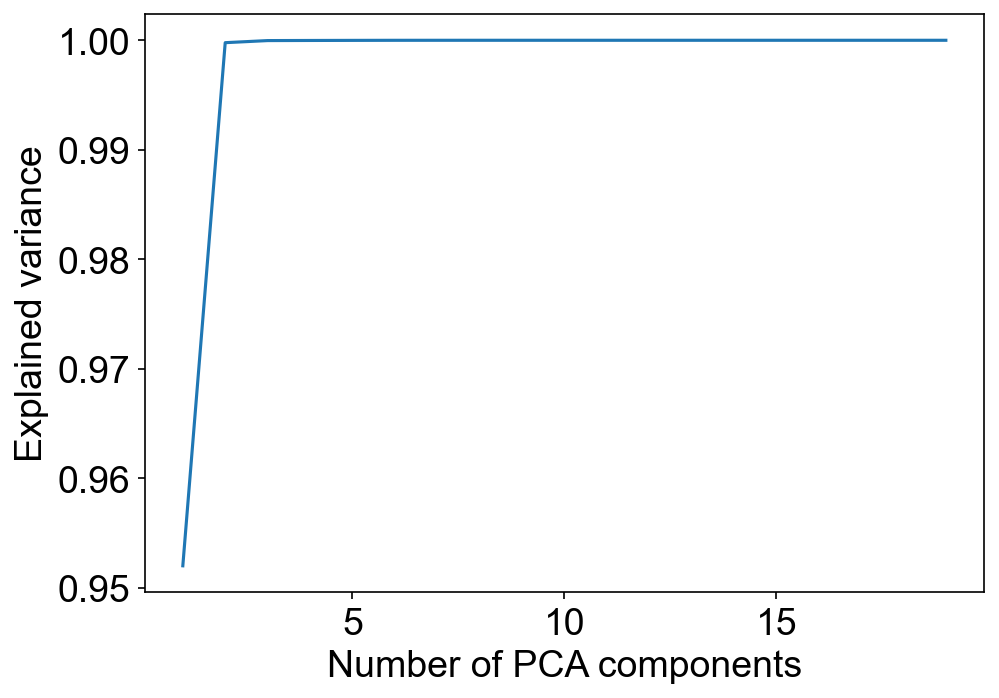

In [47]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [48]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.390108203578247

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

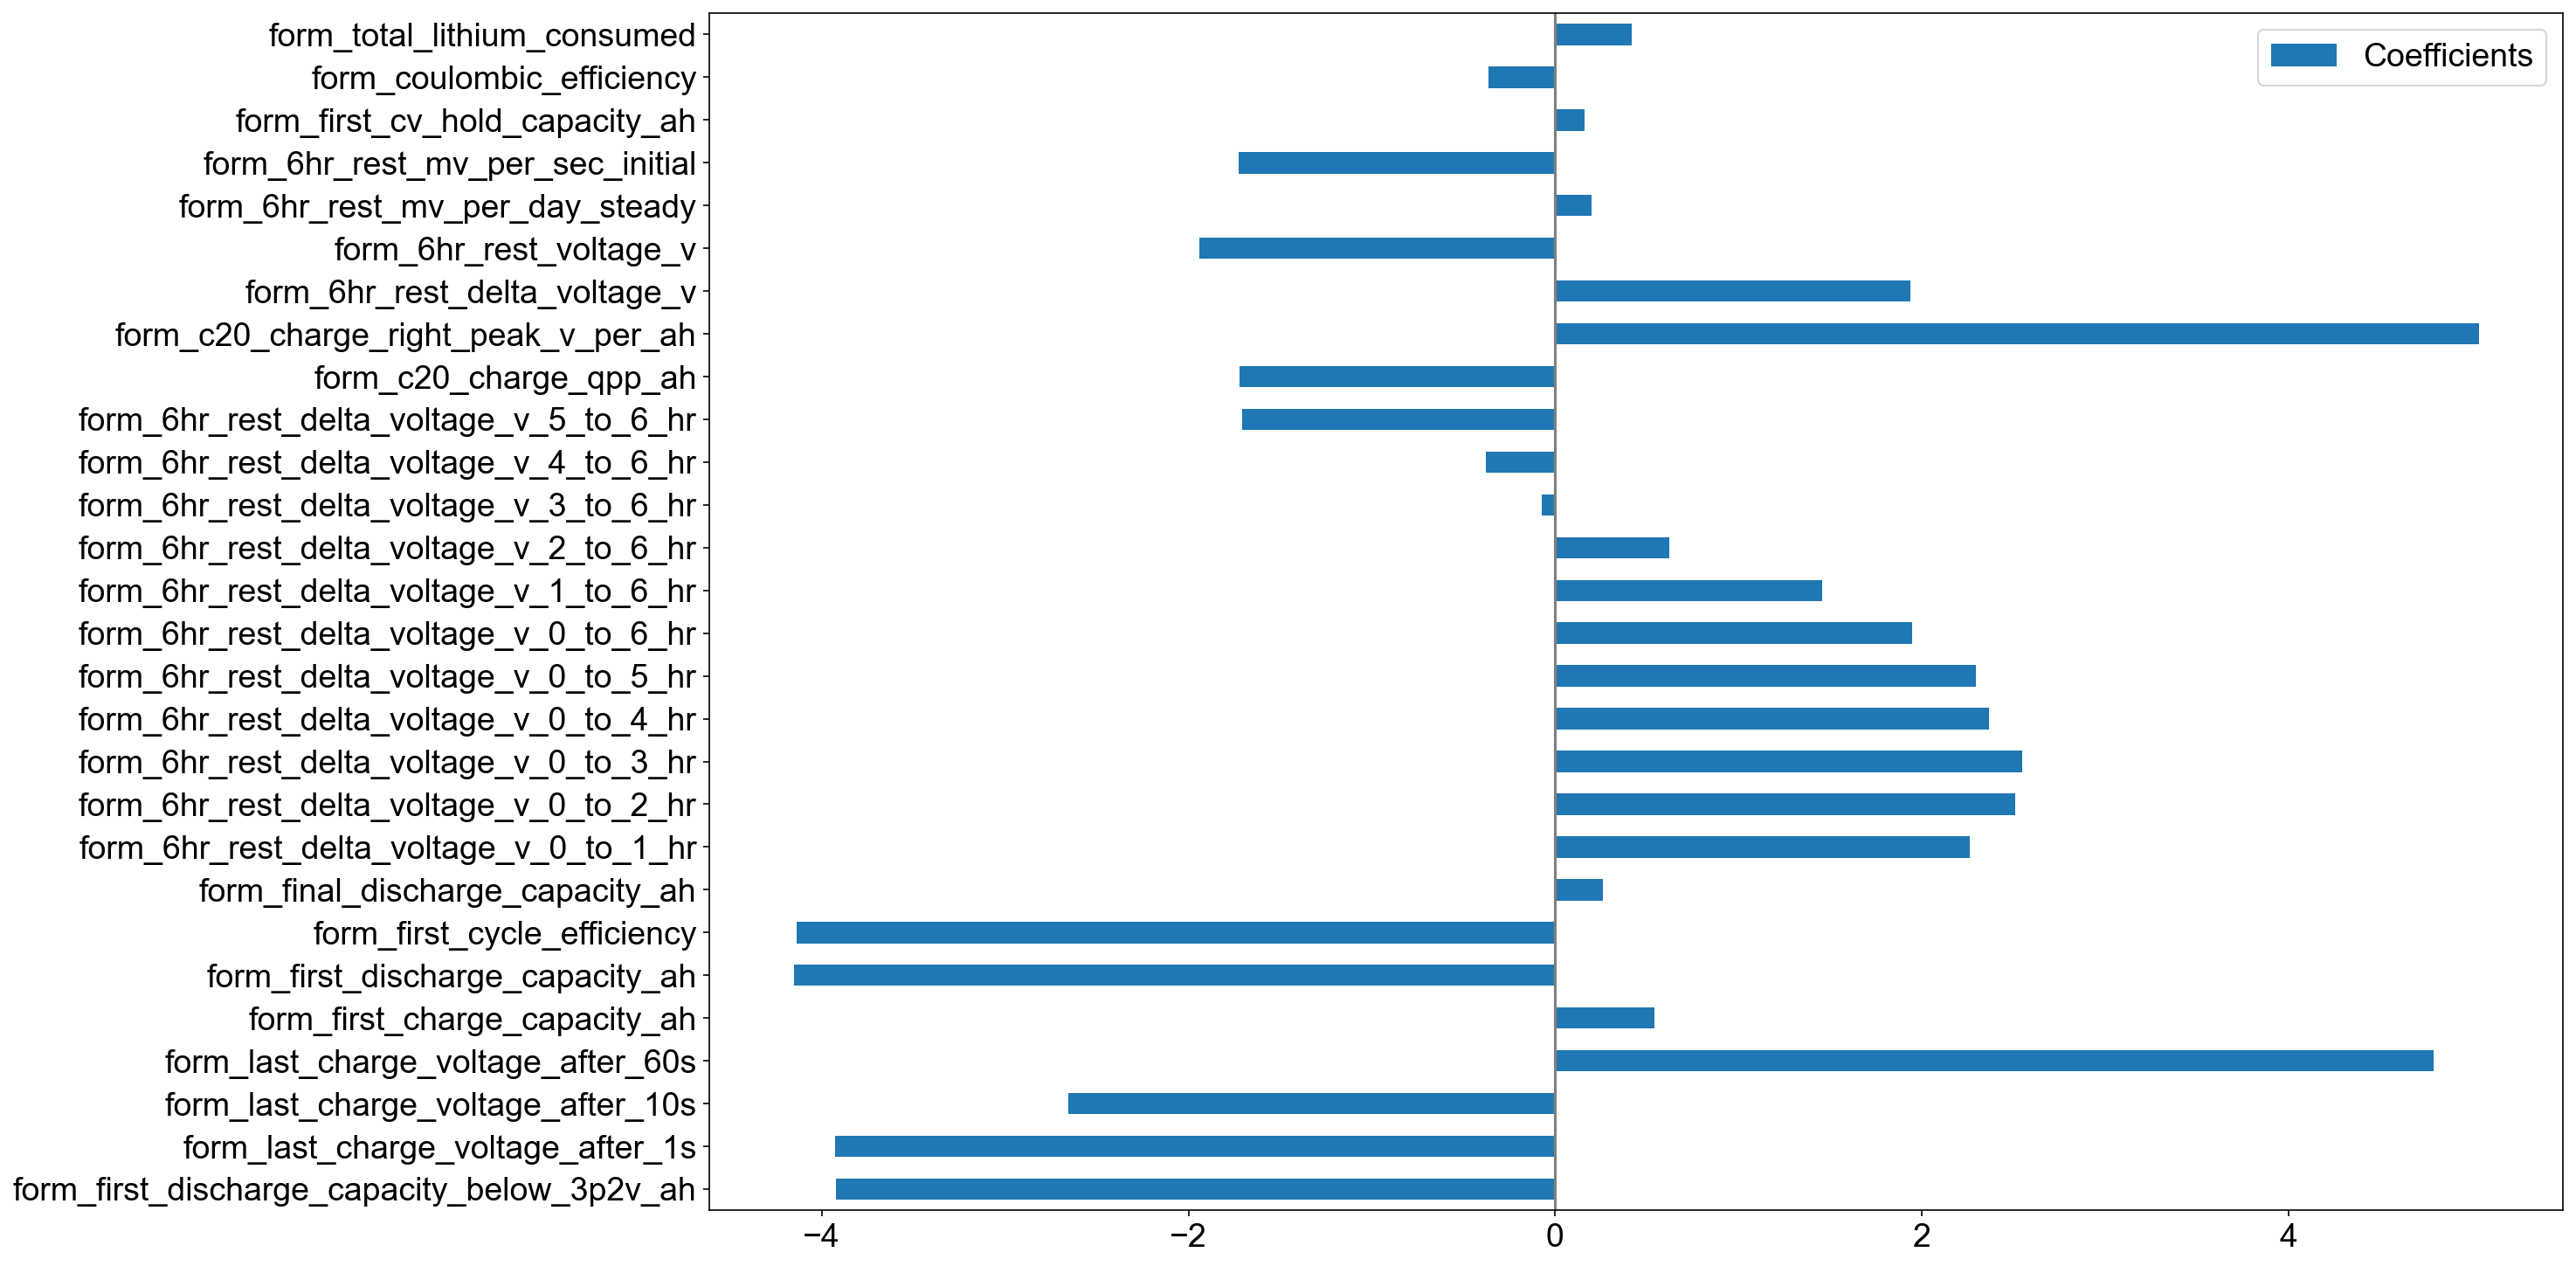

In [49]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

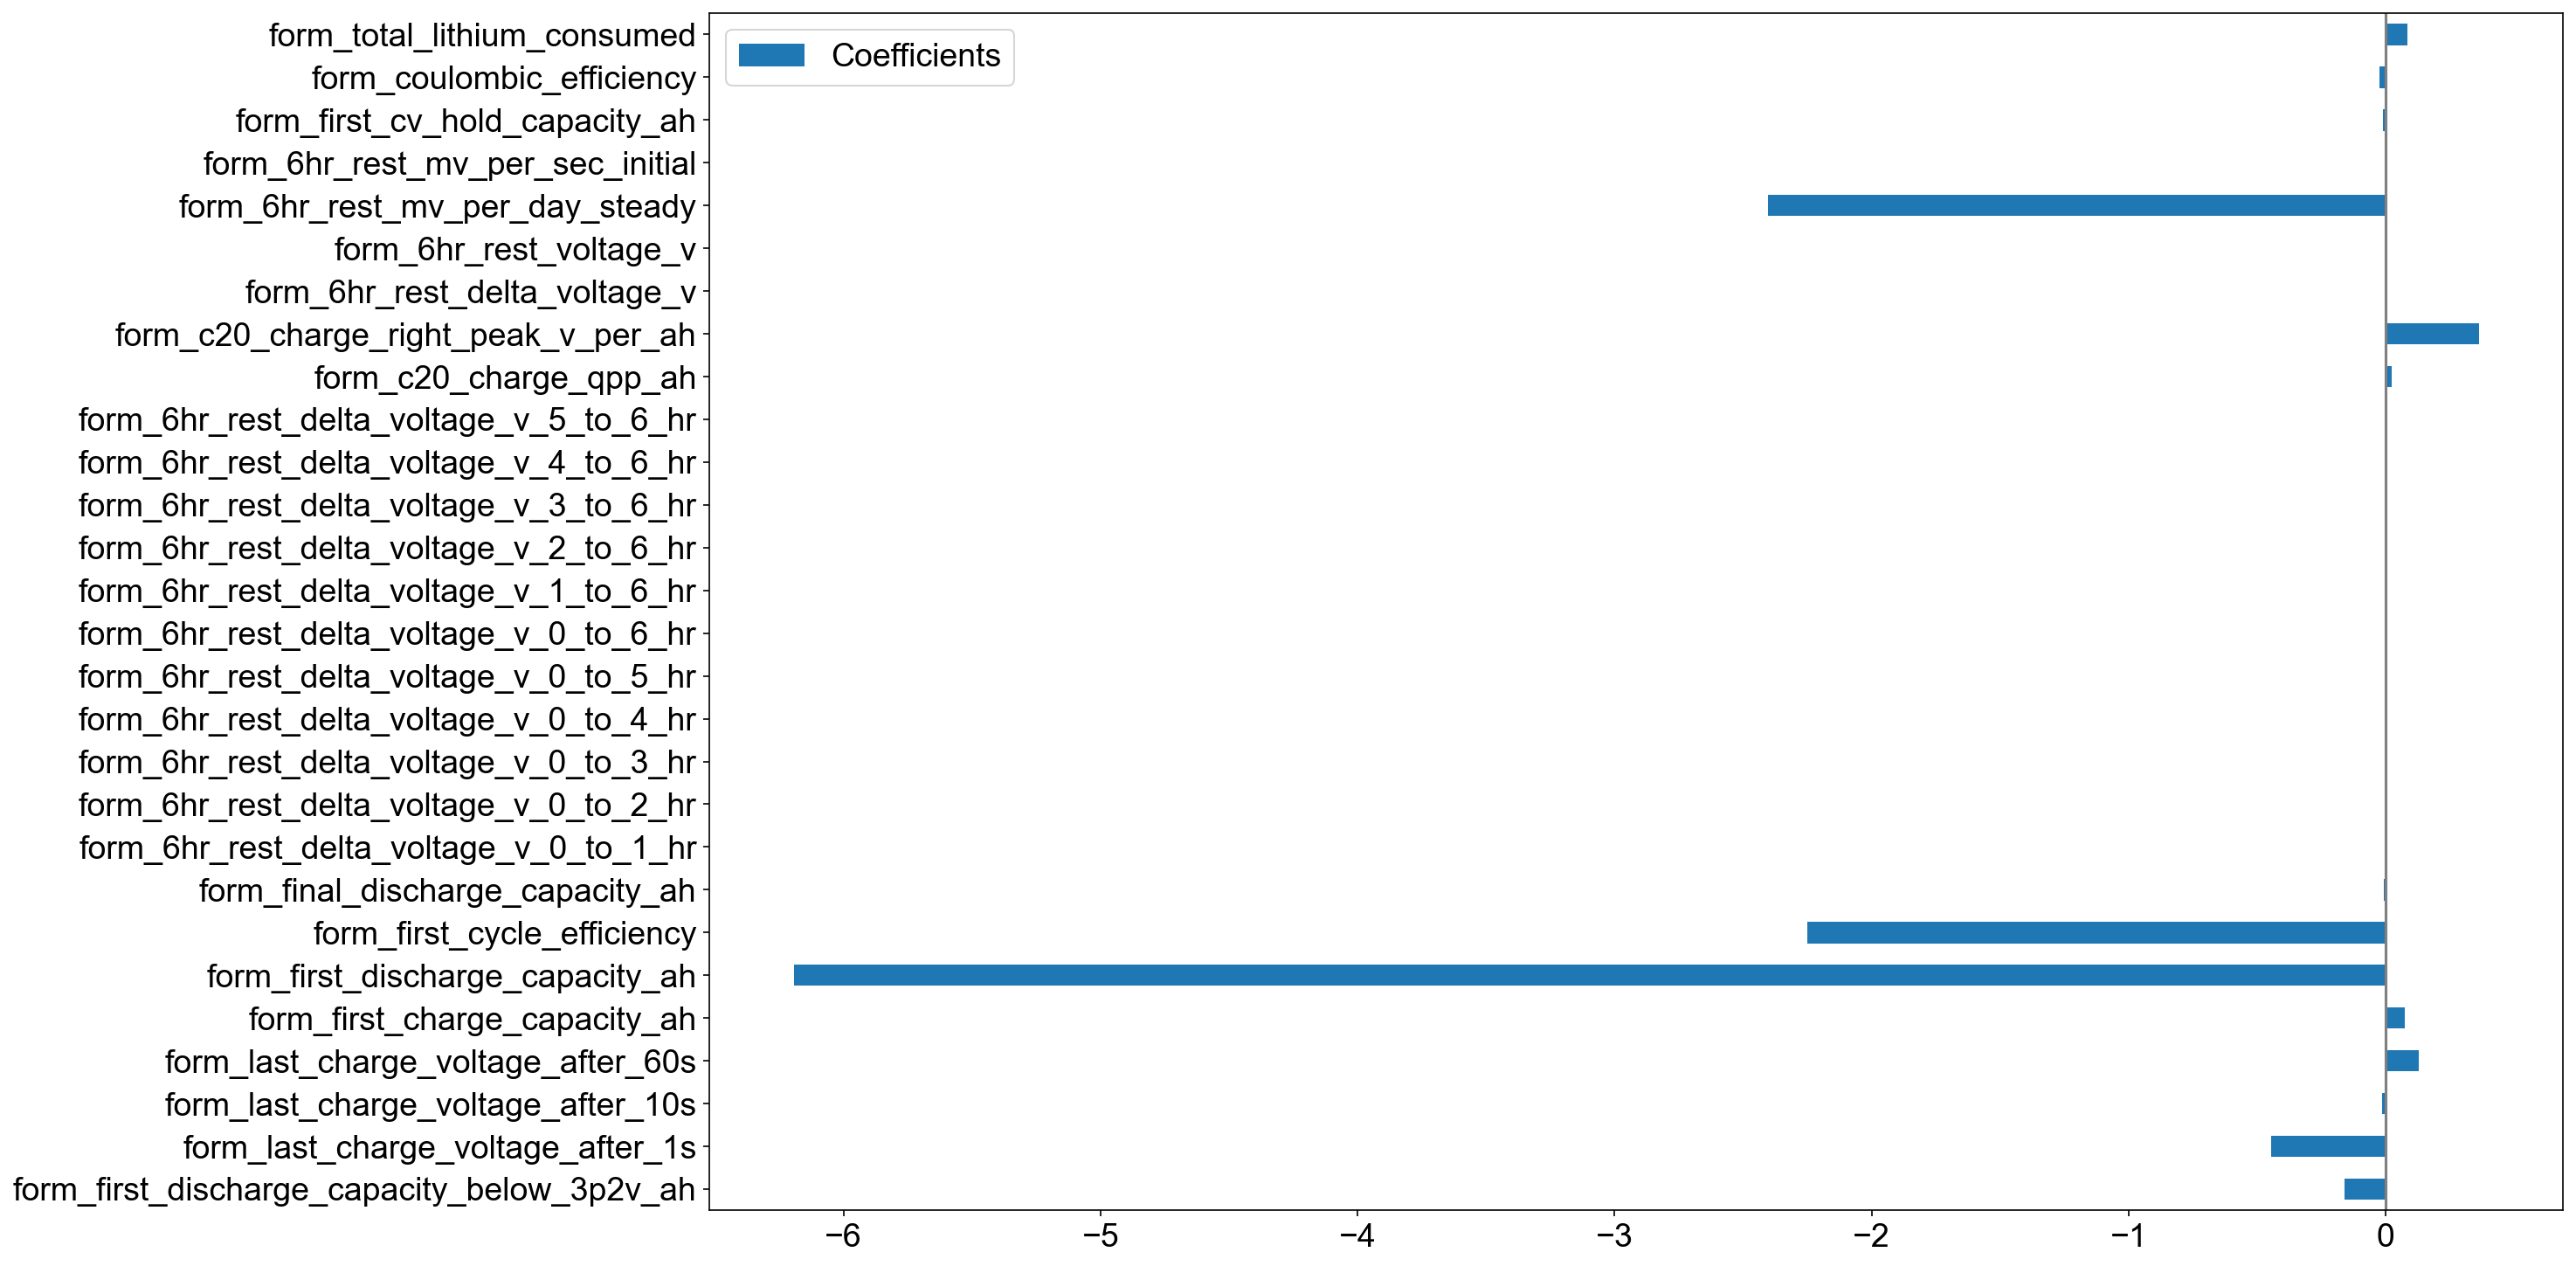

In [50]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [51]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.75 (2.46 std)


In [52]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_total_lithium_consumed                       7.67 (2.84 std)


# Including features up to cycle 3

In [53]:
c3_select = lambda x: ((x.endswith("_c3") or x.startswith("esoh_c3_") or x.startswith("rpt_c3_"))
                       and not any(s in x for s in ["LLI", "LAM", "Qcomp", "C20_loss"]))
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [54]:
df_c3.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct       1.000000
cycles_to_60_pct       0.995579
cycles_to_70_pct       0.976940
cycles_to_80_pct       0.971337
esoh_c3_x100           0.812759
                         ...   
dcr_10s_5_soc_at_c3   -0.792791
esoh_c3_neg_excess    -0.829288
esoh_c3_Cn            -0.831688
esoh_c3_CnCp          -0.845651
esoh_c3_np_ratio      -0.845651
Name: cycles_to_50_pct, Length: 54, dtype: float64

In [55]:
for a in np.logspace(-2,2):
    out = train_and_test_model(df, ["esoh_c3_np_ratio"],#,"form_first_discharge_capacity_ah"], 
                               yvar, to_plot=0, model=Ridge(a), num_experiments=1000, log=True)
    print(f"{a:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

0.01                                              8.05 (1.86 std)
0.012067926406393288                              8.10 (1.80 std)
0.014563484775012436                              7.96 (1.80 std)
0.017575106248547922                              8.01 (1.87 std)
0.021209508879201904                              7.94 (1.83 std)
0.025595479226995357                              7.96 (1.79 std)
0.030888435964774818                              7.98 (1.82 std)
0.0372759372031494                                7.91 (1.84 std)
0.04498432668969444                               7.96 (1.89 std)
0.054286754393238594                              7.97 (1.88 std)
0.0655128556859551                                7.98 (1.84 std)
0.07906043210907697                               8.05 (1.80 std)
0.09540954763499938                               7.91 (1.85 std)
0.1151395399326447                                7.99 (1.89 std)
0.13894954943731375                               7.92 (1.85 std)
0.16768329

PCA

In [56]:
pca = PCA()
pca.fit(df[form_features + c3_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:3])
# fig, ax = plt.subplots()
# ax.plot(range(1,len(cumsum)+1),cumsum)
# ax.set_xlabel("Number of PCA components")
# ax.set_ylabel("Explained variance")
# fig.savefig(OUTPUT_DIR + "pca_with_c3.pdf")

[0.84254389 0.99324955 0.99994753]


So now we have two interesting directions

In [57]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = form_features + c3_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

12.414883334570202

# Features for the paper

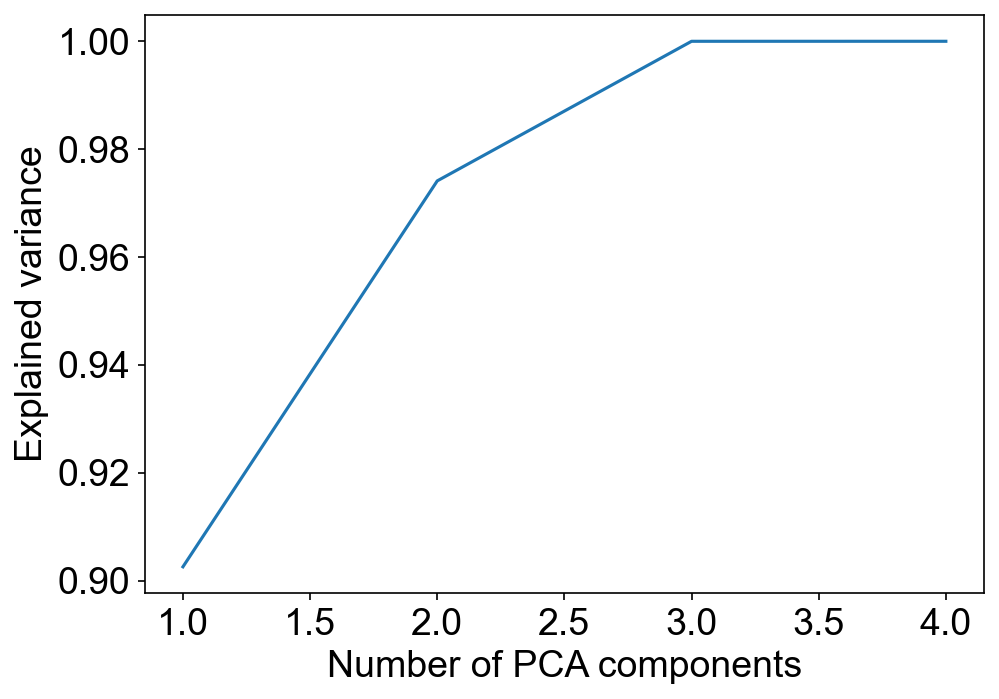

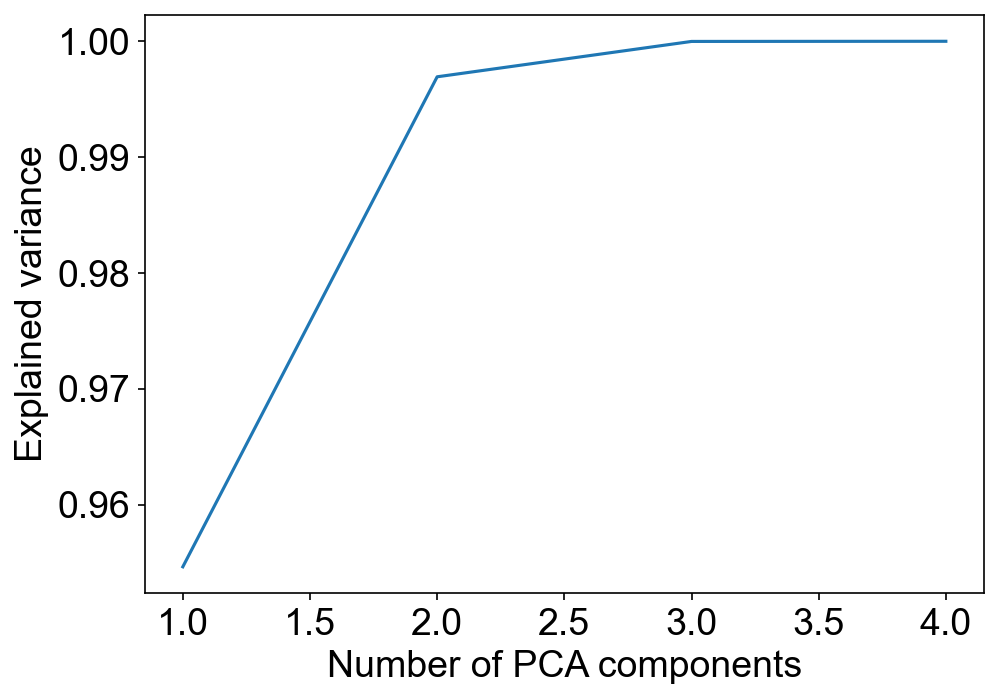

In [72]:
features = [
    "var_q_1c_c100_c10_ah",
    "form_total_lithium_consumed",
    "form_final_discharge_capacity_ah",
    "form_coulombic_efficiency",
    "dcr_10s_5_soc_at_c3",
]
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    pca = PCA()
    pca.fit(df_[features[1:]])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots()
    ax.plot(range(1,len(cumsum)+1),cumsum)
    ax.set_xlabel("Number of PCA components")
    ax.set_ylabel("Explained variance")
    fig.savefig(OUTPUT_DIR + f"pca_paper_features_{temp}.pdf")

In [71]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    out = train_and_test_model(df_, features[0], yvar70, to_plot=0, model=DummyRegressor(), num_experiments=1000)
    print(f"{'Dummy regressor (predict mean)':<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    for f in features:
        out = train_and_test_model(df_, f, yvar70, to_plot=0, model=LinearRegression(), num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features"
    out = train_and_test_model(df_, features[1:-1], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features + R10s"
    out = train_and_test_model(df_, features[1:], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

hot
Dummy regressor (predict mean)                    train: 14.06 (0.86 std)		test: 14.85 (3.51 std)
var_q_1c_c100_c10_ah                              train: 10.08 (1.13 std)		test: 11.43 (4.09 std)
form_total_lithium_consumed                       train: 13.97 (0.99 std)		test: 16.00 (3.73 std)


KeyboardInterrupt: 

# Nested cross-validation

In [62]:
import random

def nested(df_, xvars, yvar, num_experiments=None):
    log = False
    to_plot = False

    # Number of trials
    num_experiments = num_experiments or 100

    # Unpack and filter data
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df_[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

    percent_error_list_outer = []
    percent_error_train_list_outer = []

    for i in range(num_experiments):
#         if i%20 == 0:
#             print(i)
        df_random = df_nonans.sample(frac=1)

        # save 3 cases for validation
        validate = df_random.iloc[:3]
        train_test = df_random.iloc[3:]
        all_indices = list(range(len(train_test)))

        percent_error_list = []
        percent_error_train_list = []

        best = np.inf

        for alpha in np.logspace(-5,5,20):
            model = Ridge(alpha)
            for i in range(4):
                test = list(range(i*4,(i+1)*4))
                train = [x for x in all_indices if x not in test]
                Xy_train = train_test.iloc[train]
                Xy_test = train_test.iloc[test]

                X_train = Xy_train[xvars]
                y_train = np.array(Xy_train[yvar])
                X_test = Xy_test[xvars]
                y_test = np.array(Xy_test[yvar])

                # apply standard scaler (fit only on train, transform both train and test)
                # keep originals for pltos
            #     X_train_original = X_train
            #     X_test_original = X_test
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                (model, corr) = build_model(X_train, y_train, model)

                y_pred = model.predict(X_test)
                y_train_pred = model.predict(X_train)
            #     y_train_mean = np.mean(y_train)

            #     r2_score = model.score(X_test, y_test)

            #     if log is True:
            #         y_train = np.exp(y_train)
            #         y_pred = np.exp(y_pred)
            #         y_test = np.exp(y_test)
            #         y_train_mean = np.exp(y_train_mean)

            #     rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
                percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
                percent_error_train = np.mean(np.abs(y_train_pred - y_train)/y_train) * 100
            #     baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

            #     rmse_list.append(rmse)
                percent_error_list.append(percent_error)
                percent_error_train_list.append(percent_error_train)

                #     r2_score_list.append(r2_score)
            #     baseline_rmse_list.append(baseline_rmse)
                #         intercept_list.append(model.intercept_)
                #         coef_list.append(model.coef_)
            #     corr_list.append(corr)
            score = np.mean(percent_error_list)
    #         print(score,best)
            if score < best:
                best = score
                alpha_best = alpha

        # Keep the best model
        model = Ridge(alpha_best)
        X_train = train_test[xvars]
        y_train = np.array(train_test[yvar])
        X_test = validate[xvars]
        y_test = np.array(validate[yvar])
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        (model, corr) = build_model(X_train, y_train, model)
        y_pred = model.predict(X_test)
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        percent_error_list_outer.append(percent_error)
        y_train_pred = model.predict(X_train)
        percent_error_train = np.mean(np.abs(y_train_pred - y_train)/y_train) * 100
        percent_error_train_list_outer.append(percent_error_train)
    #     print(percent_error)
    out = {
        "percent_error_train": np.mean(percent_error_train_list_outer),
        "percent_error_train_std": np.std(percent_error_train_list_outer),
        "percent_error": np.mean(percent_error_list_outer),
        "percent_error_std": np.std(percent_error_list_outer),
        "alpha": alpha_best,
    }
    return out

# model = LinearRegression()
# xvars = form_features +c3_features
xvars = ["form_first_discharge_capacity_ah"]
out = nested(df_hot, xvars, yvar70)
print(out)


{'percent_error_train': 6.335903119895452, 'percent_error_train_std': 0.6453872097062744, 'percent_error': 7.8969756586787625, 'percent_error_std': 3.3217100483209765, 'alpha': 0.1623776739188721}


In [61]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    for f in features:
        out = nested(df_, [f], yvar70, num_experiments=100)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
             + f"\t{out['alpha']}")
    f = "form features"
    out = nested(df_, features[1:-1], yvar70, num_experiments=100)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")
    f = "form features + R10s"
    out = nested(df_, features[1:], yvar70, num_experiments=100)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")

hot
0
20
40
60
80
var_q_1c_c100_c10_ah                              train: 10.31 (1.08 std)		test: 11.58 (5.00 std)	1e-05
0
20
40
60
80
form_total_lithium_consumed                       train: 14.01 (0.75 std)		test: 15.24 (3.93 std)	100000.0
0
20
40
60
80
form_final_discharge_capacity_ah                  train: 13.54 (0.80 std)		test: 14.99 (4.49 std)	784.7599703514607
0
20
40
60
80
form_coulombic_efficiency                         train: 14.03 (0.76 std)		test: 15.25 (4.09 std)	100000.0
0
20
40
60
80
dcr_10s_5_soc_at_c3                               train: 6.47 (0.62 std)		test: 7.20 (3.24 std)	0.5455594781168515
0
20
40
60
80
form features                                     train: 13.51 (1.19 std)		test: 15.56 (5.28 std)	100000.0
0
20
40
60
80
form features + R10s                              train: 6.29 (1.08 std)		test: 9.49 (2.95 std)	1.8329807108324339
room
0
20
40
60
80
var_q_1c_c100_c10_ah                              train: 11.80 (1.68 std)		test: 14.21 (5.71 std)	1e-05
0
20

In [63]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    for f in features:
        out = nested(df_, [f], yvar70, num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
             + f"\t{out['alpha']}")
    f = "form features"
    out = nested(df_, features[1:-1], yvar70, num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")
    f = "form features + R10s"
    out = nested(df_, features[1:], yvar70, num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")

hot
var_q_1c_c100_c10_ah                              train: 10.30 (1.08 std)		test: 11.46 (4.71 std)	1.8329807108324339
form_total_lithium_consumed                       train: 14.07 (0.78 std)		test: 15.19 (4.37 std)	100000.0
form_final_discharge_capacity_ah                  train: 13.49 (0.80 std)		test: 15.06 (4.01 std)	1e-05
form_coulombic_efficiency                         train: 14.08 (0.74 std)		test: 15.03 (4.35 std)	100000.0
dcr_10s_5_soc_at_c3                               train: 6.46 (0.57 std)		test: 7.39 (2.93 std)	0.5455594781168515
form features                                     train: 13.41 (1.13 std)		test: 15.82 (4.83 std)	100000.0
form features + R10s                              train: 6.47 (1.04 std)		test: 9.05 (2.99 std)	6.1584821106602545
room
var_q_1c_c100_c10_ah                              train: 11.64 (1.65 std)		test: 14.46 (5.26 std)	100000.0
form_total_lithium_consumed                       train: 12.23 (1.15 std)		test: 13.96 (4.56 std)	1.832980710832